# Using physics-based features to train the e_electronic model for prediction

- Get Data from csv file

In [1]:
# import the necessary libraries
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression

In [2]:
# some global variables
TEST_SIZE = 0.30
RANDOM_STATE = 42
N_SPLITS = 10
# The depth of the decision tree
BEST_DEPTH = None

FIG_PATH = '../figures/domain_based/unClustered/e_electronic/'

In [3]:
data = pd.read_csv('../data/domain_based_data.csv')

In [4]:
data.head()

,crystal_system,space_group,band_gap,volume,density,density_atomic,formation_energy_per_atom,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,...,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity,e_electronic,e_ionic,e_total
0,4,11,0.7792,316.341404,5.022717,22.595815,-1.124079,16.0,56.0,40.0,...,215.0,110.0,130.428571,0.89,2.58,1.69,2.230000,9.929365,7.118969,17.048334
1,3,19,2.8980,253.915299,3.764366,15.869706,-3.099174,8.0,41.0,33.0,...,164.0,107.0,88.250000,1.60,3.98,2.38,3.115000,4.102533,13.469477,17.572010
2,5,1,1.7212,196.220495,3.094976,28.031499,-0.766100,16.0,38.0,22.0,...,195.0,90.0,121.857143,0.95,2.58,1.63,2.232857,6.045051,12.443616,18.488667
3,4,12,2.0944,620.336826,2.901260,12.923684,-1.948264,8.0,26.0,18.0,...,166.0,100.0,86.333333,0.93,3.44,2.51,2.953333,3.096120,6.499905,9.596025
4,3,62,7.4812,374.200384,1.860992,9.355010,-1.970766,1.0,9.0,8.0,...,84.0,53.0,50.700000,2.04,3.98,1.94,2.980000,1.866232,4.350314,6.216546


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7262 entries, 0 to 7261
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   crystal_system                        7262 non-null   int64  
 1   space_group                           7262 non-null   int64  
 2   band_gap                              7262 non-null   float64
 3   volume                                7262 non-null   float64
 4   density                               7262 non-null   float64
 5   density_atomic                        7262 non-null   float64
 6   formation_energy_per_atom             7262 non-null   float64
 7   MagpieData minimum Number             7262 non-null   float64
 8   MagpieData maximum Number             7262 non-null   float64
 9   MagpieData range Number               7262 non-null   float64
 10  MagpieData mean Number                7262 non-null   float64
 11  MagpieData minimu

- Create X and y 

In [6]:
X = data.drop(columns=['e_total', 'e_ionic', 'e_electronic'])
y = data['e_electronic']

- Train and test set split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

- Use StandScaler to scale X_train 

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [9]:
# scale x_test
X_test_scaled = scaler.transform(X_test)

## Linear regression model

In [10]:
def model_cross_train(model, X, y):
    '''Train the model model on X and return the results of cross-validation:
        1. scores（neg_root_mean_squared_error）
        2. y_hat'''
    kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
    y_hat = cross_val_predict(model, X, y, cv=kfold)
    return scores, y_hat

# After determining all the hyperparameters, train the model on the entire training set with the best hyperparameters
def model_final_train(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def model_test(model, X_test, y_test):
    '''Test the model on the test set and return the results:
        1. mean_squared_error
        2. mean_absolute_error
        3. y_pred'''
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, mae, y_pred

In [11]:
# draw parity plot
def parity_plot(mse, mae, y_test, y_pred, y_name="e_electronic", title='Parity Plot', fig_path=None, dpi=300):
    # draw parity plot
    fig, ax = plt.subplots(figsize=(8, 8), dpi=dpi)
    ax.scatter(y_test, y_pred, s=2, c="#9cc3e5", marker="^")
    ax.plot(y_test, y_test, c="#aad390", zorder=-5)
    ax.set_title(title)
    # relative dielectric constant, no unit
    ax.set_xlabel("Actual " + y_name)
    ax.set_ylabel("Predicted " + y_name)
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    # make it diagonal distribution
    ax.set_aspect("equal", adjustable="box")
    # set the range of x and y to be the same
    ax.set_xlim([0, 50])
    ax.set_ylim([0, 50])
    # inward ticks
    ax.tick_params(axis='both', direction='in', length=4) 

    ax.grid(True, linestyle="--", alpha=0.4)
    
    # draw mse and mae on the plot of top_left
    # Add bbox to the plot
    bbox_props = dict(boxstyle="round,pad=0.8", ec="#aad390", lw=0.6, facecolor="white", alpha=0.6)
    ax.text(0.05, 0.95, "MSE: {:.2f}\n\nMAE: {:.2f}".format(mse, mae), transform=ax.transAxes, 
            fontsize=6, c='#9cc3e5', verticalalignment='top', bbox=bbox_props)

    plt.show()
    if fig_path:
        # Is there the directory of the fig_path
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        fig.savefig(fig_path+title+".png", dpi=dpi, bbox_inches='tight')

In [12]:
def plot_scores(mse, mae, y_train, y_hat, title='Parity Plot', fig_path=None, dpi=300):
    '''...'''
    print(f'MSE: {mse}, MAE: {mae}')

    # parity plot
    parity_plot(mse, mae, y_train, y_hat, y_name='e_electronic', title=title, fig_path=fig_path, dpi=dpi)

### Train the model

MSE: -145.53221010550791, MAE: 0


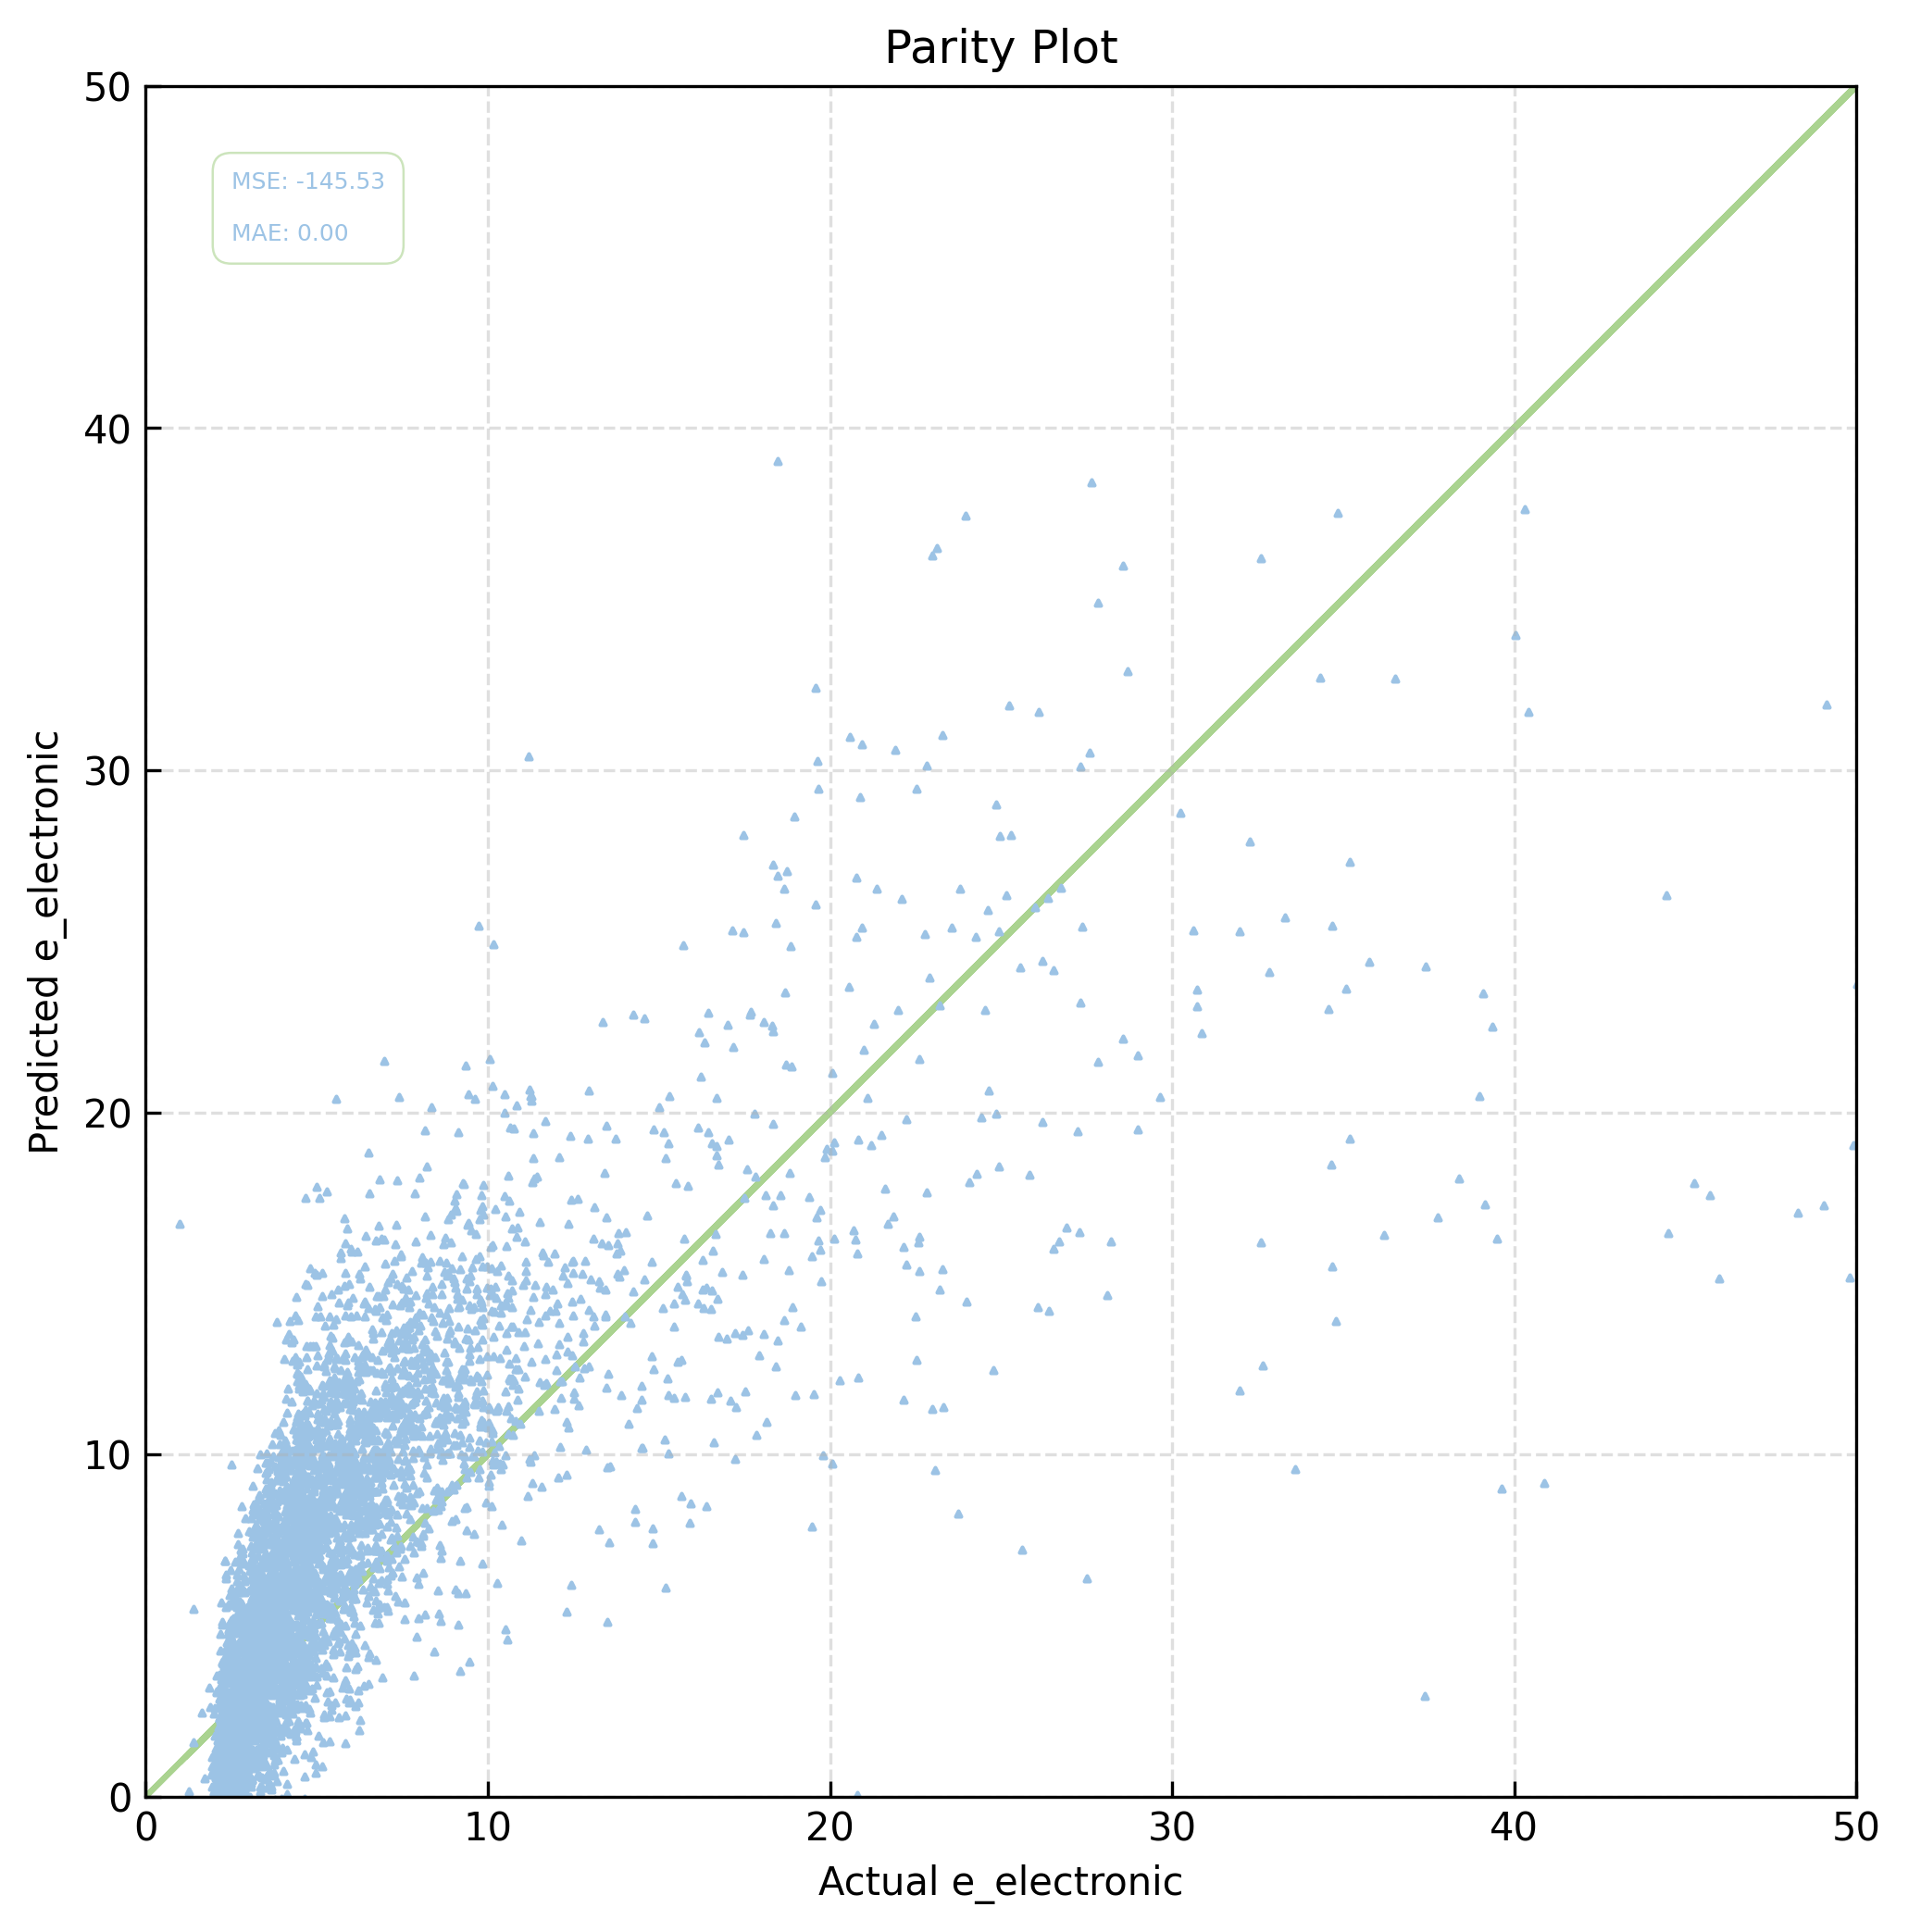

In [13]:
# This model uses the analytical solution, so it does not include the setting of the learning rate
lr = LinearRegression()
scores, y_hat = model_cross_train(lr, X_train_scaled, y_train)

fig = plot_scores(-scores.mean()**2, 0, y_train, y_hat)

In [14]:
lr.fit(X_train_scaled, y_train)

LinearRegression()

### Model Test：

MSE: 127.57185324292021, MAE: 3.6684105402204232


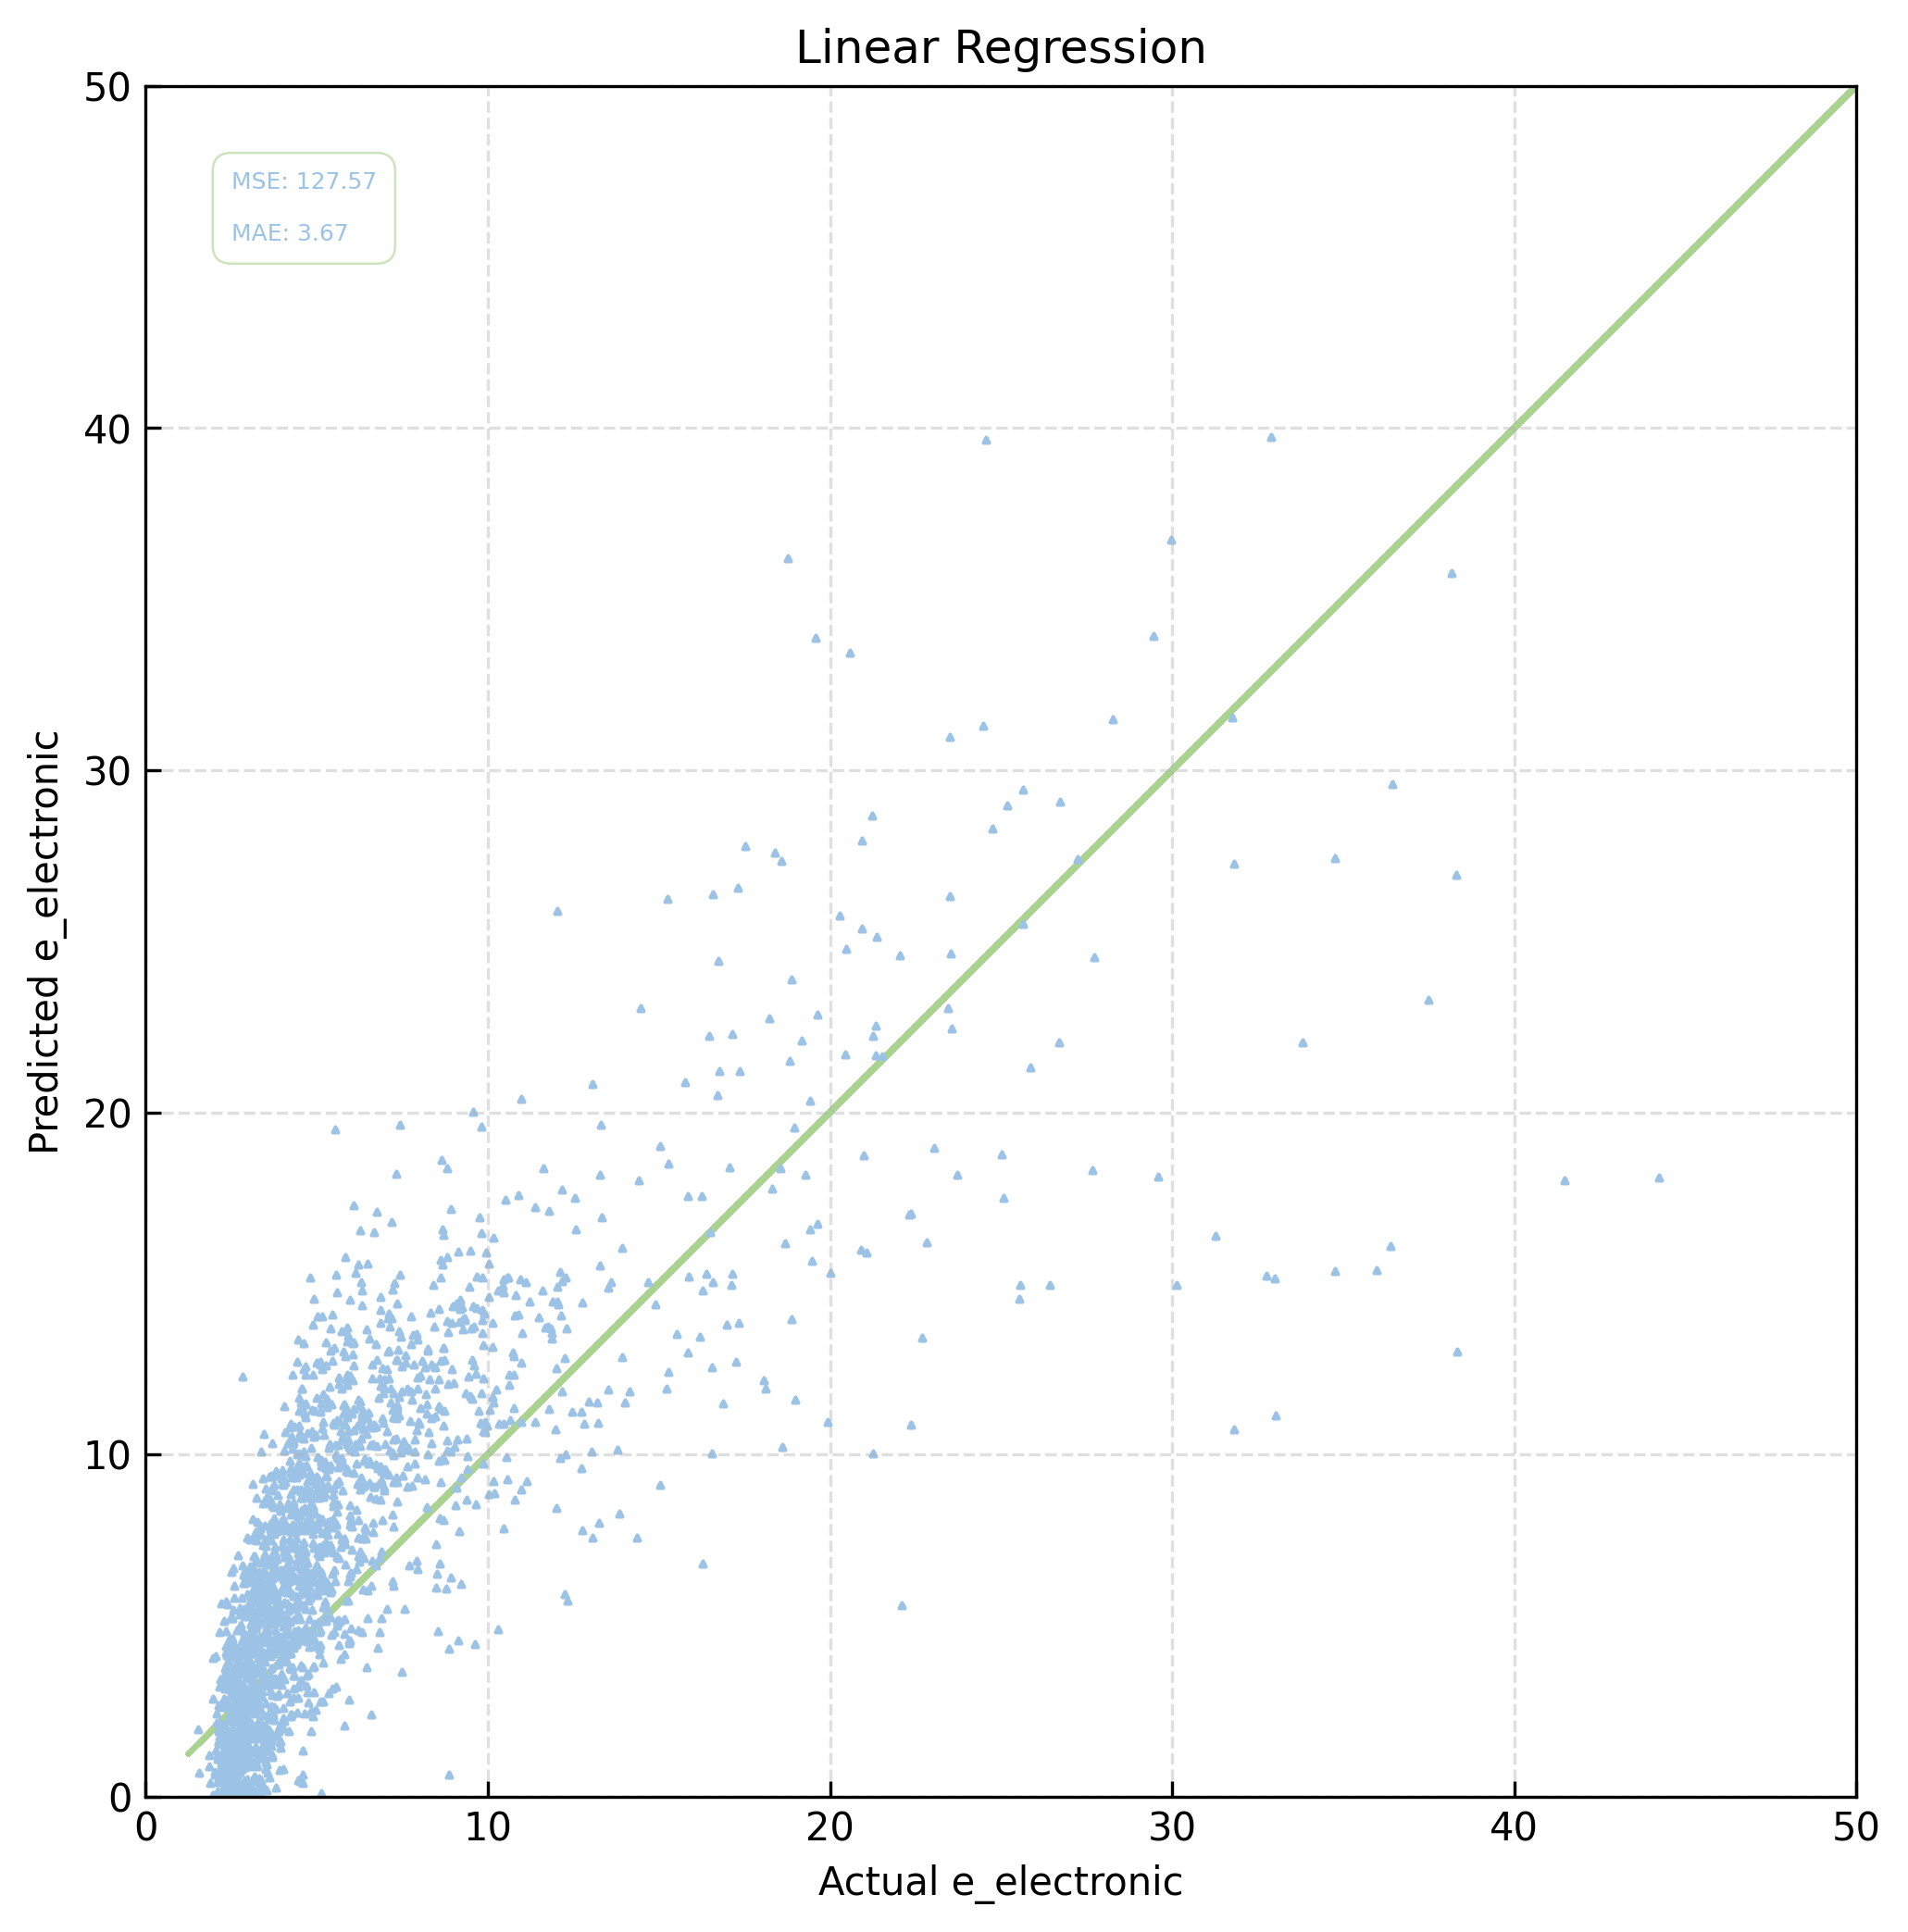

In [15]:
mse, mae, y_pred = model_test(lr, X_test_scaled, y_test)
plot_scores(mse, mae, y_test, y_pred, title='Linear Regression', fig_path=FIG_PATH)

## Decision Tree Model

-14.54313621299338 5
MSE: 211.50281090967943, MAE: 0


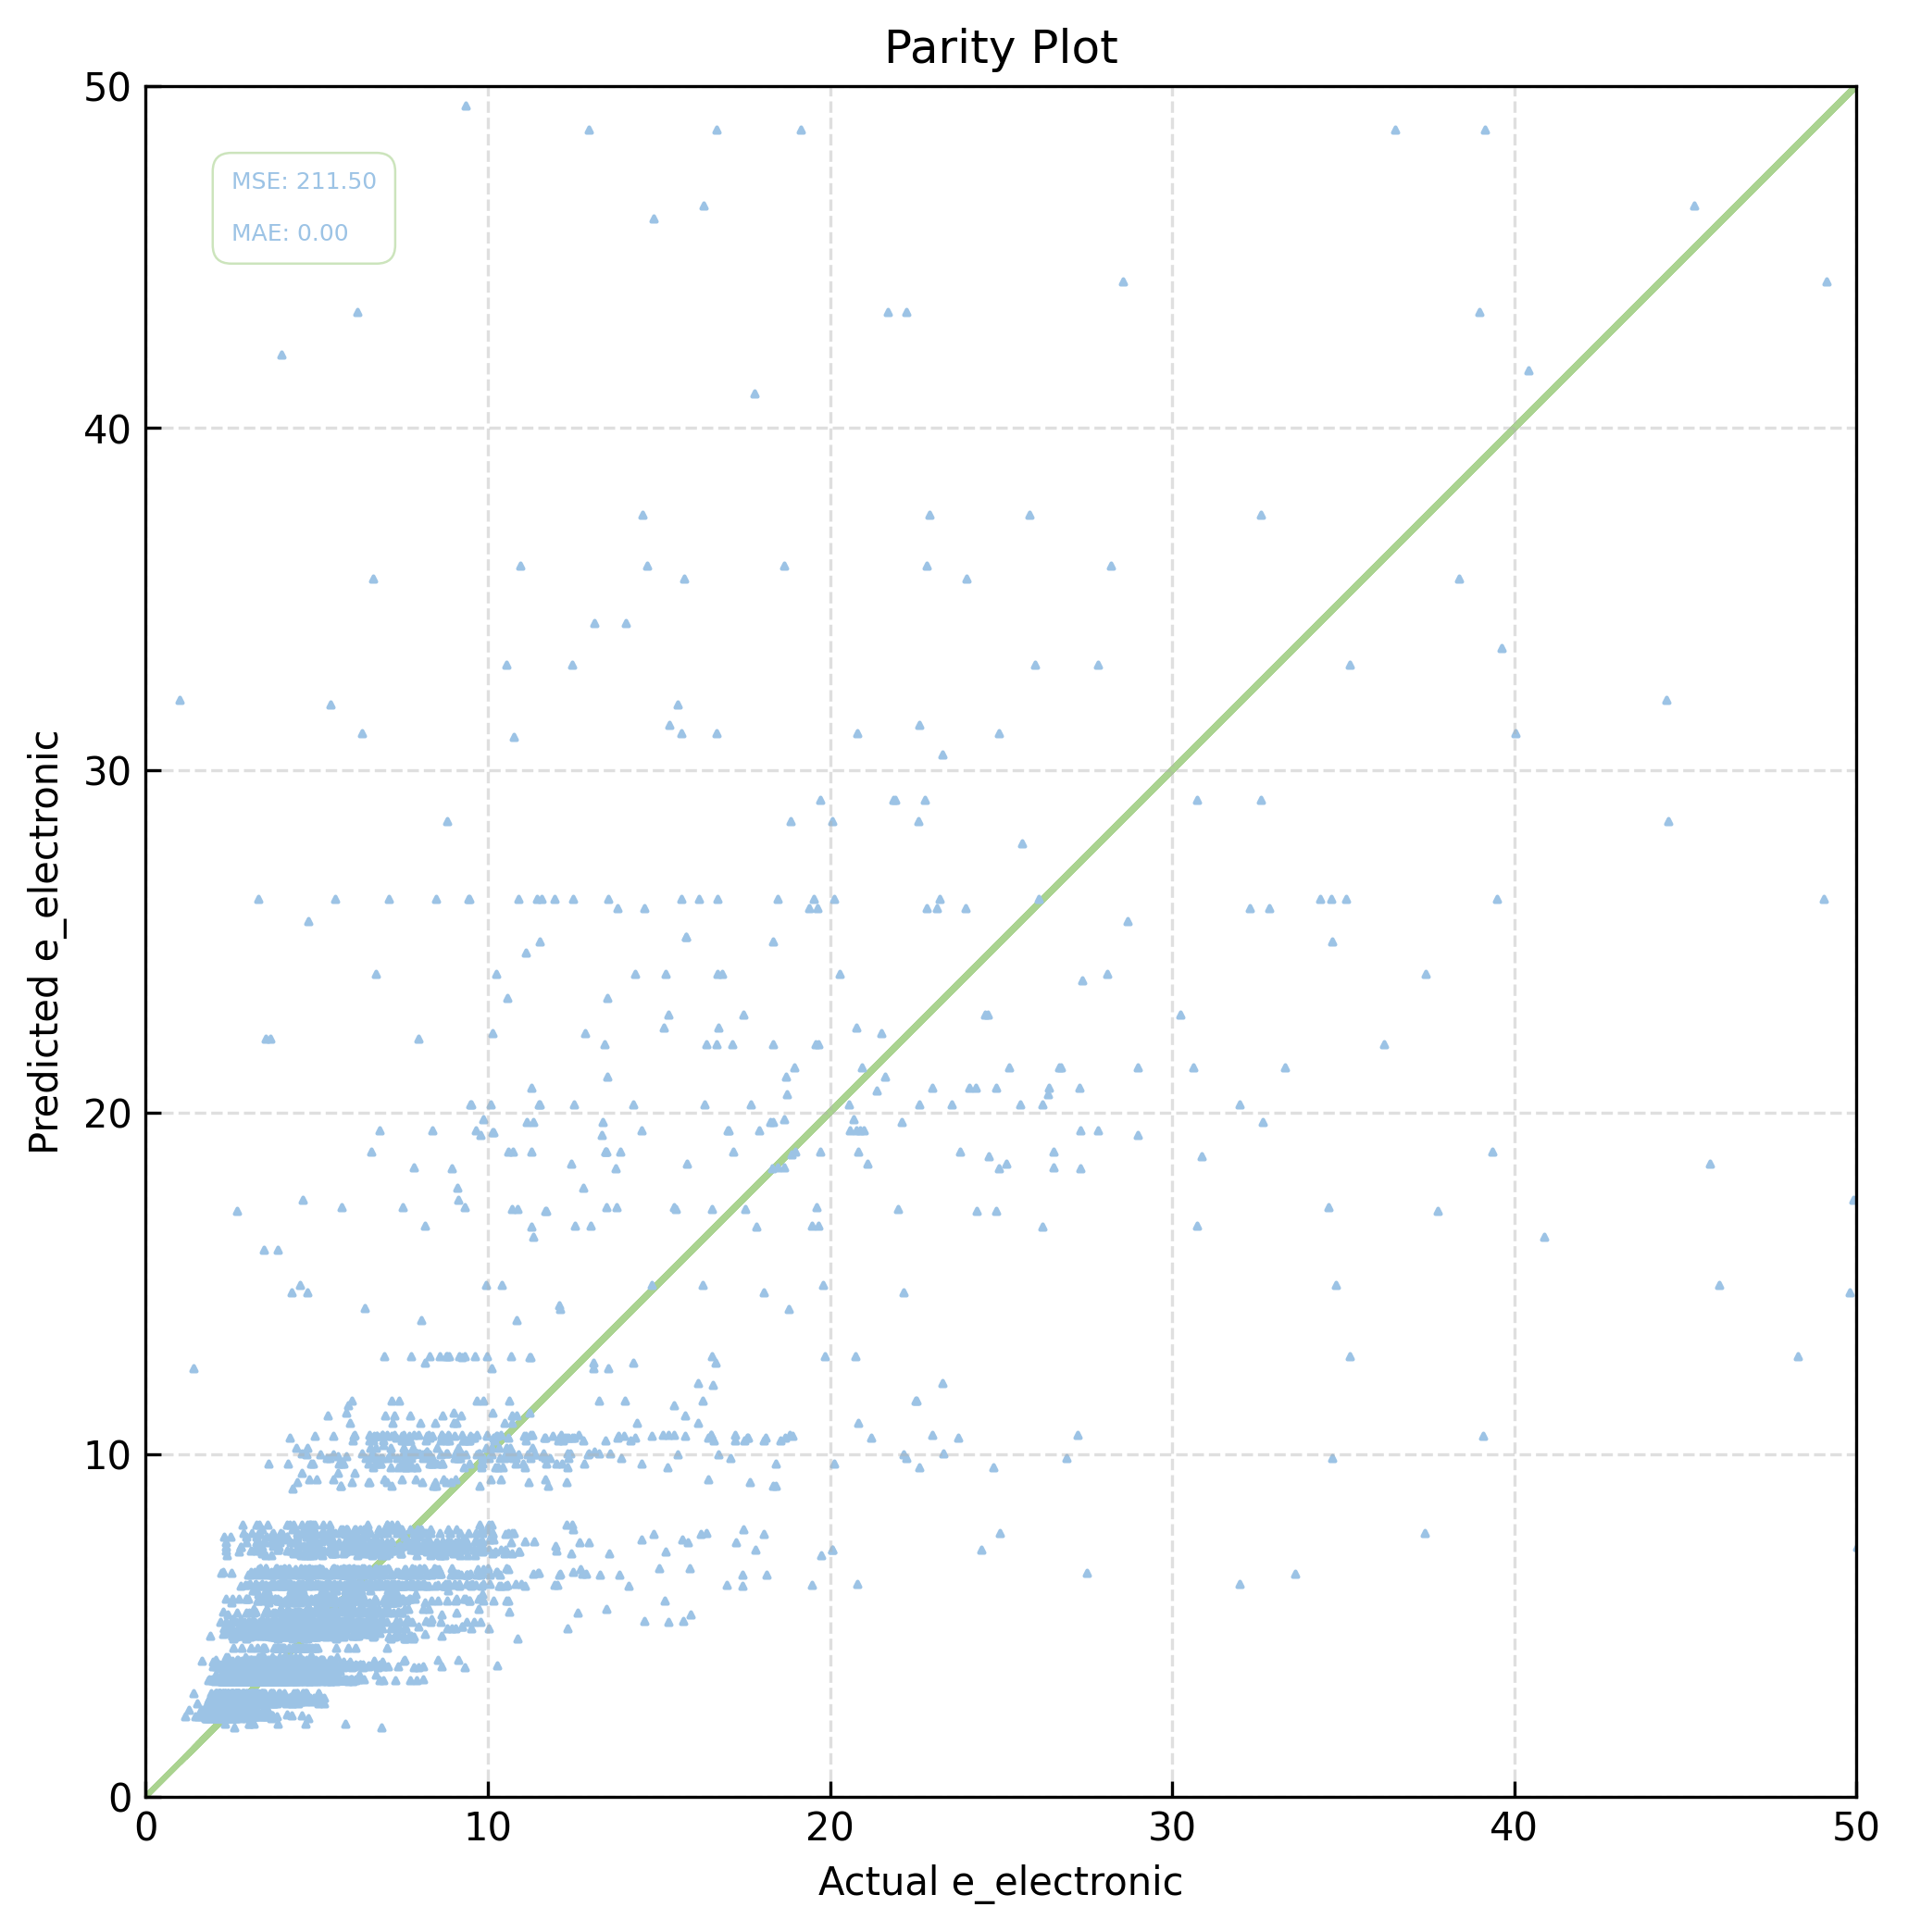

-13.8512616381583 6
MSE: 191.85744896871577, MAE: 0


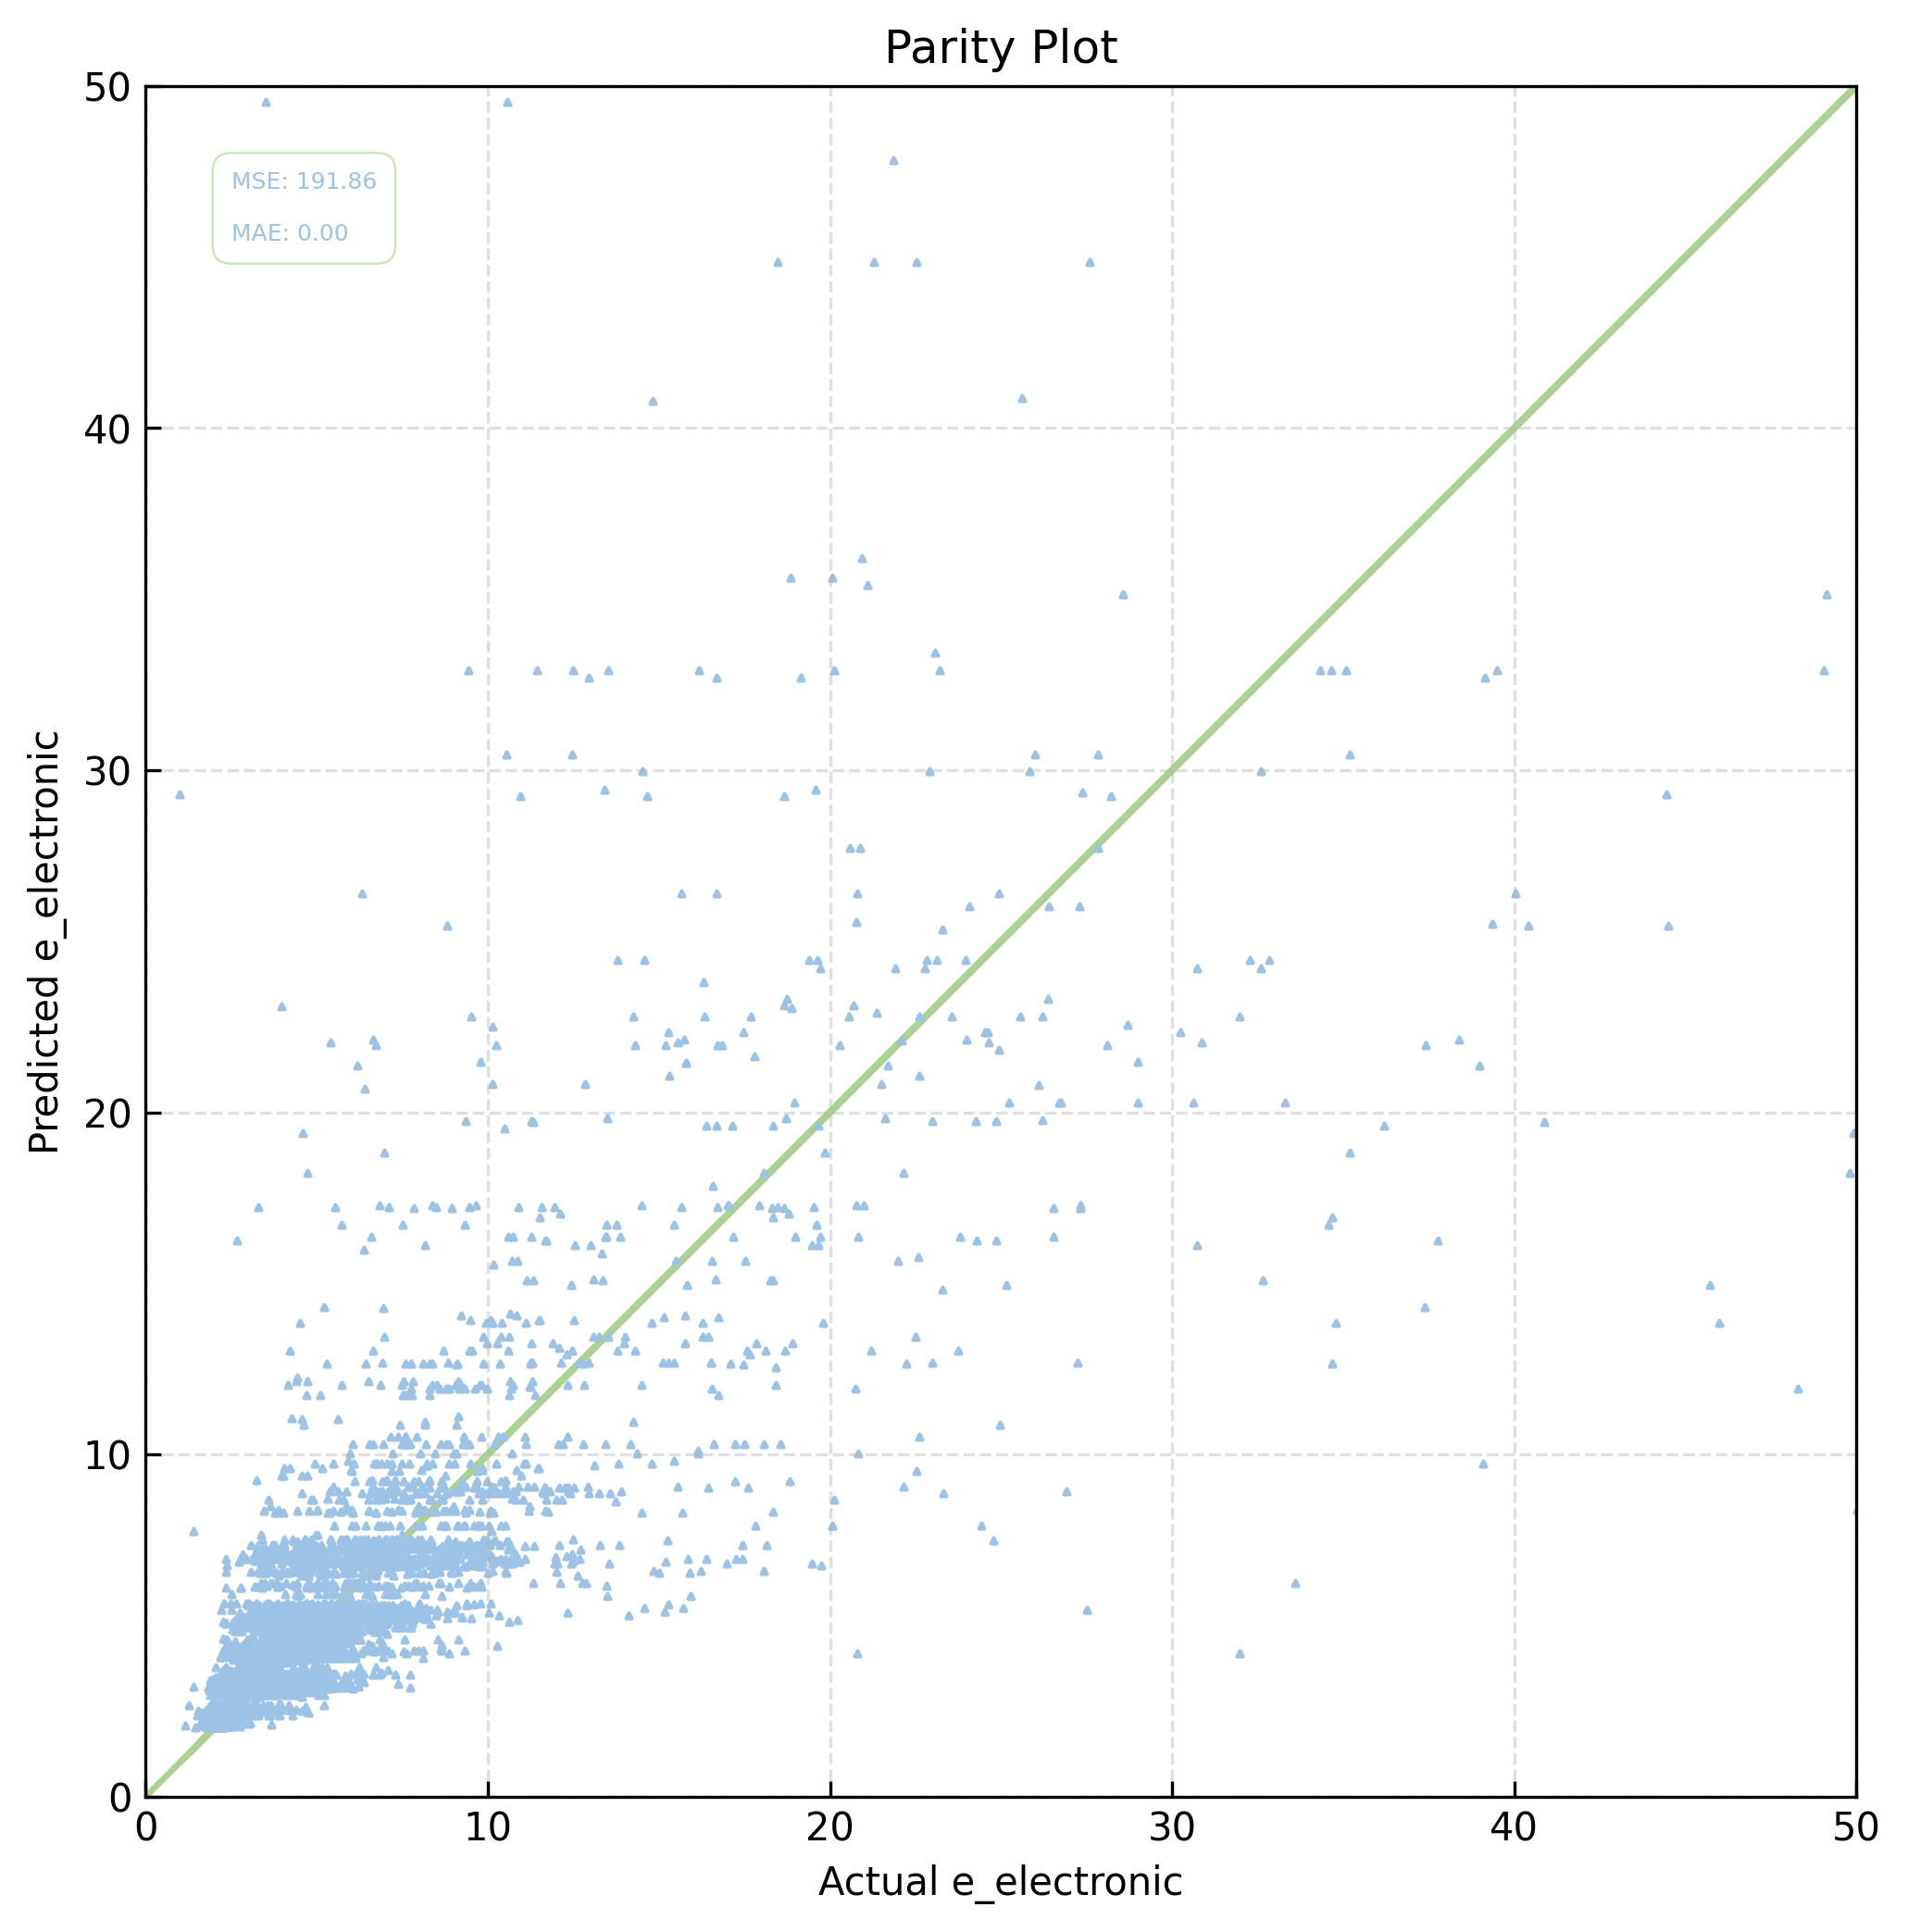

-13.652313945267036 7
MSE: 186.38567606013277, MAE: 0


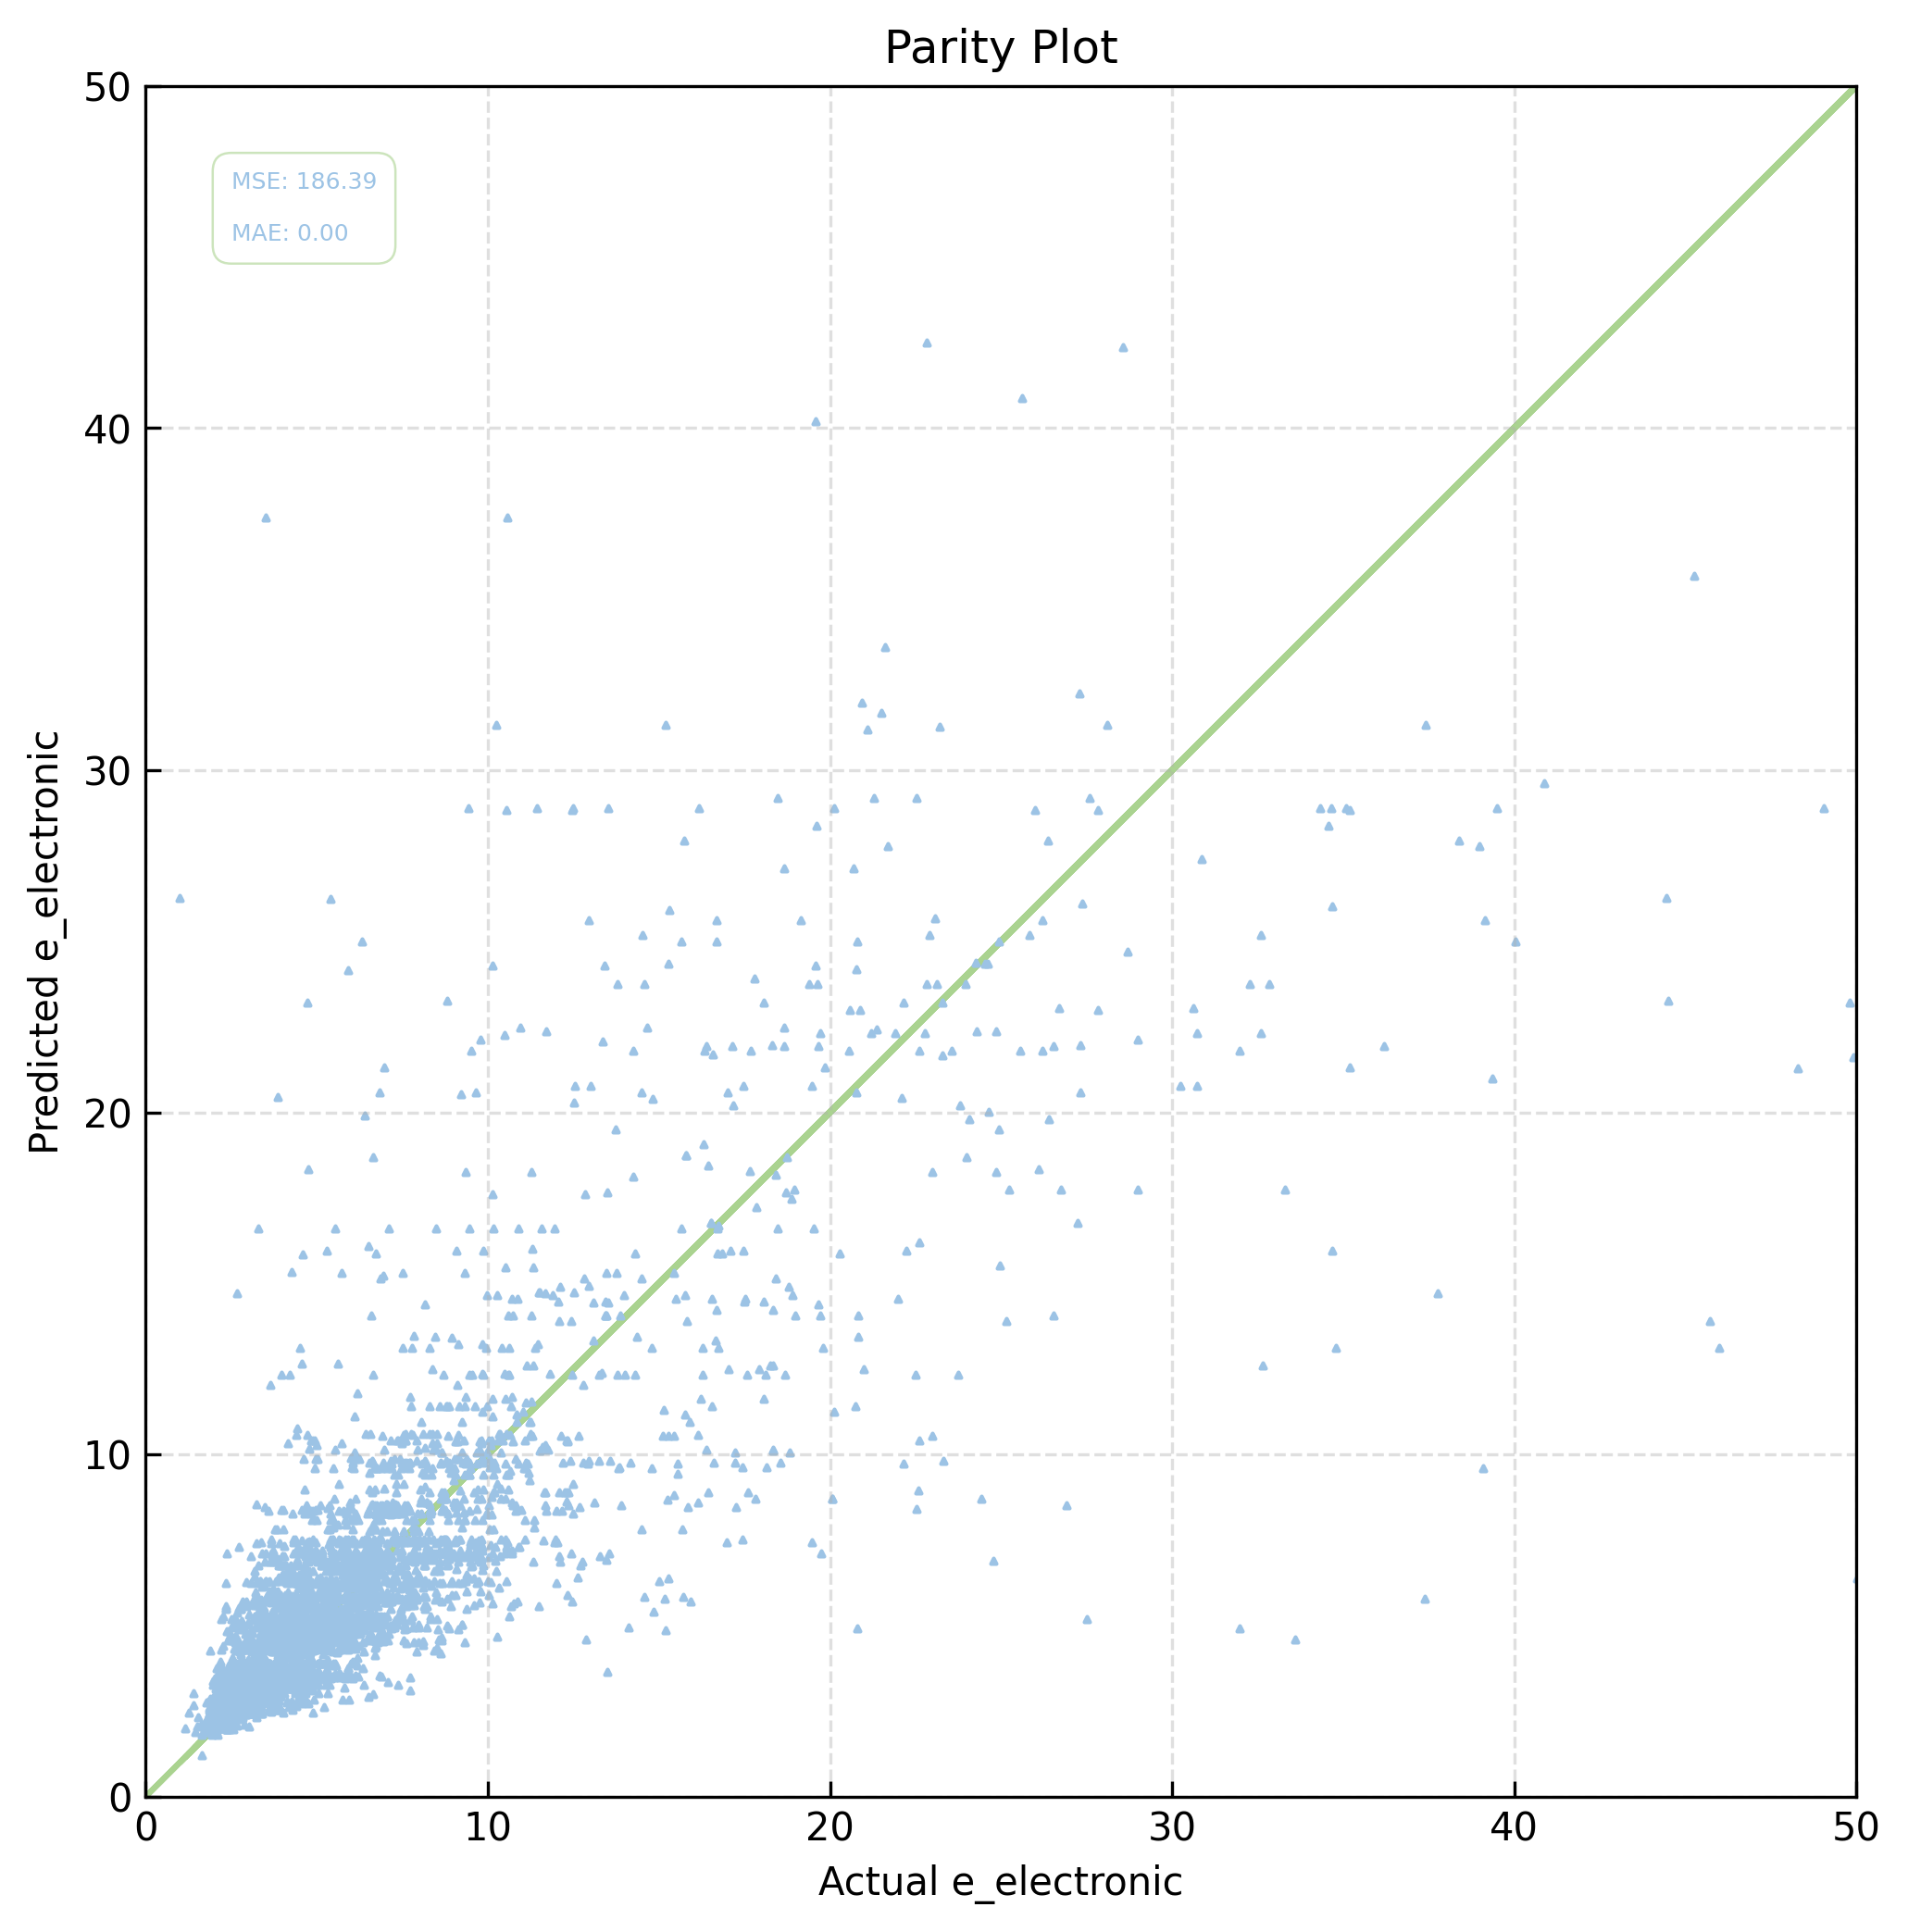

-14.44098436192194 8
-14.292333913465814 9
-13.668822803883334 10
-14.035189903639983 11
-13.704285854503492 12
-13.933445667980266 13
-14.436062991943322 14
-14.322580544084747 15
-14.49534367880021 16
-13.630107720396675 17
MSE: 185.77983646961704, MAE: 0


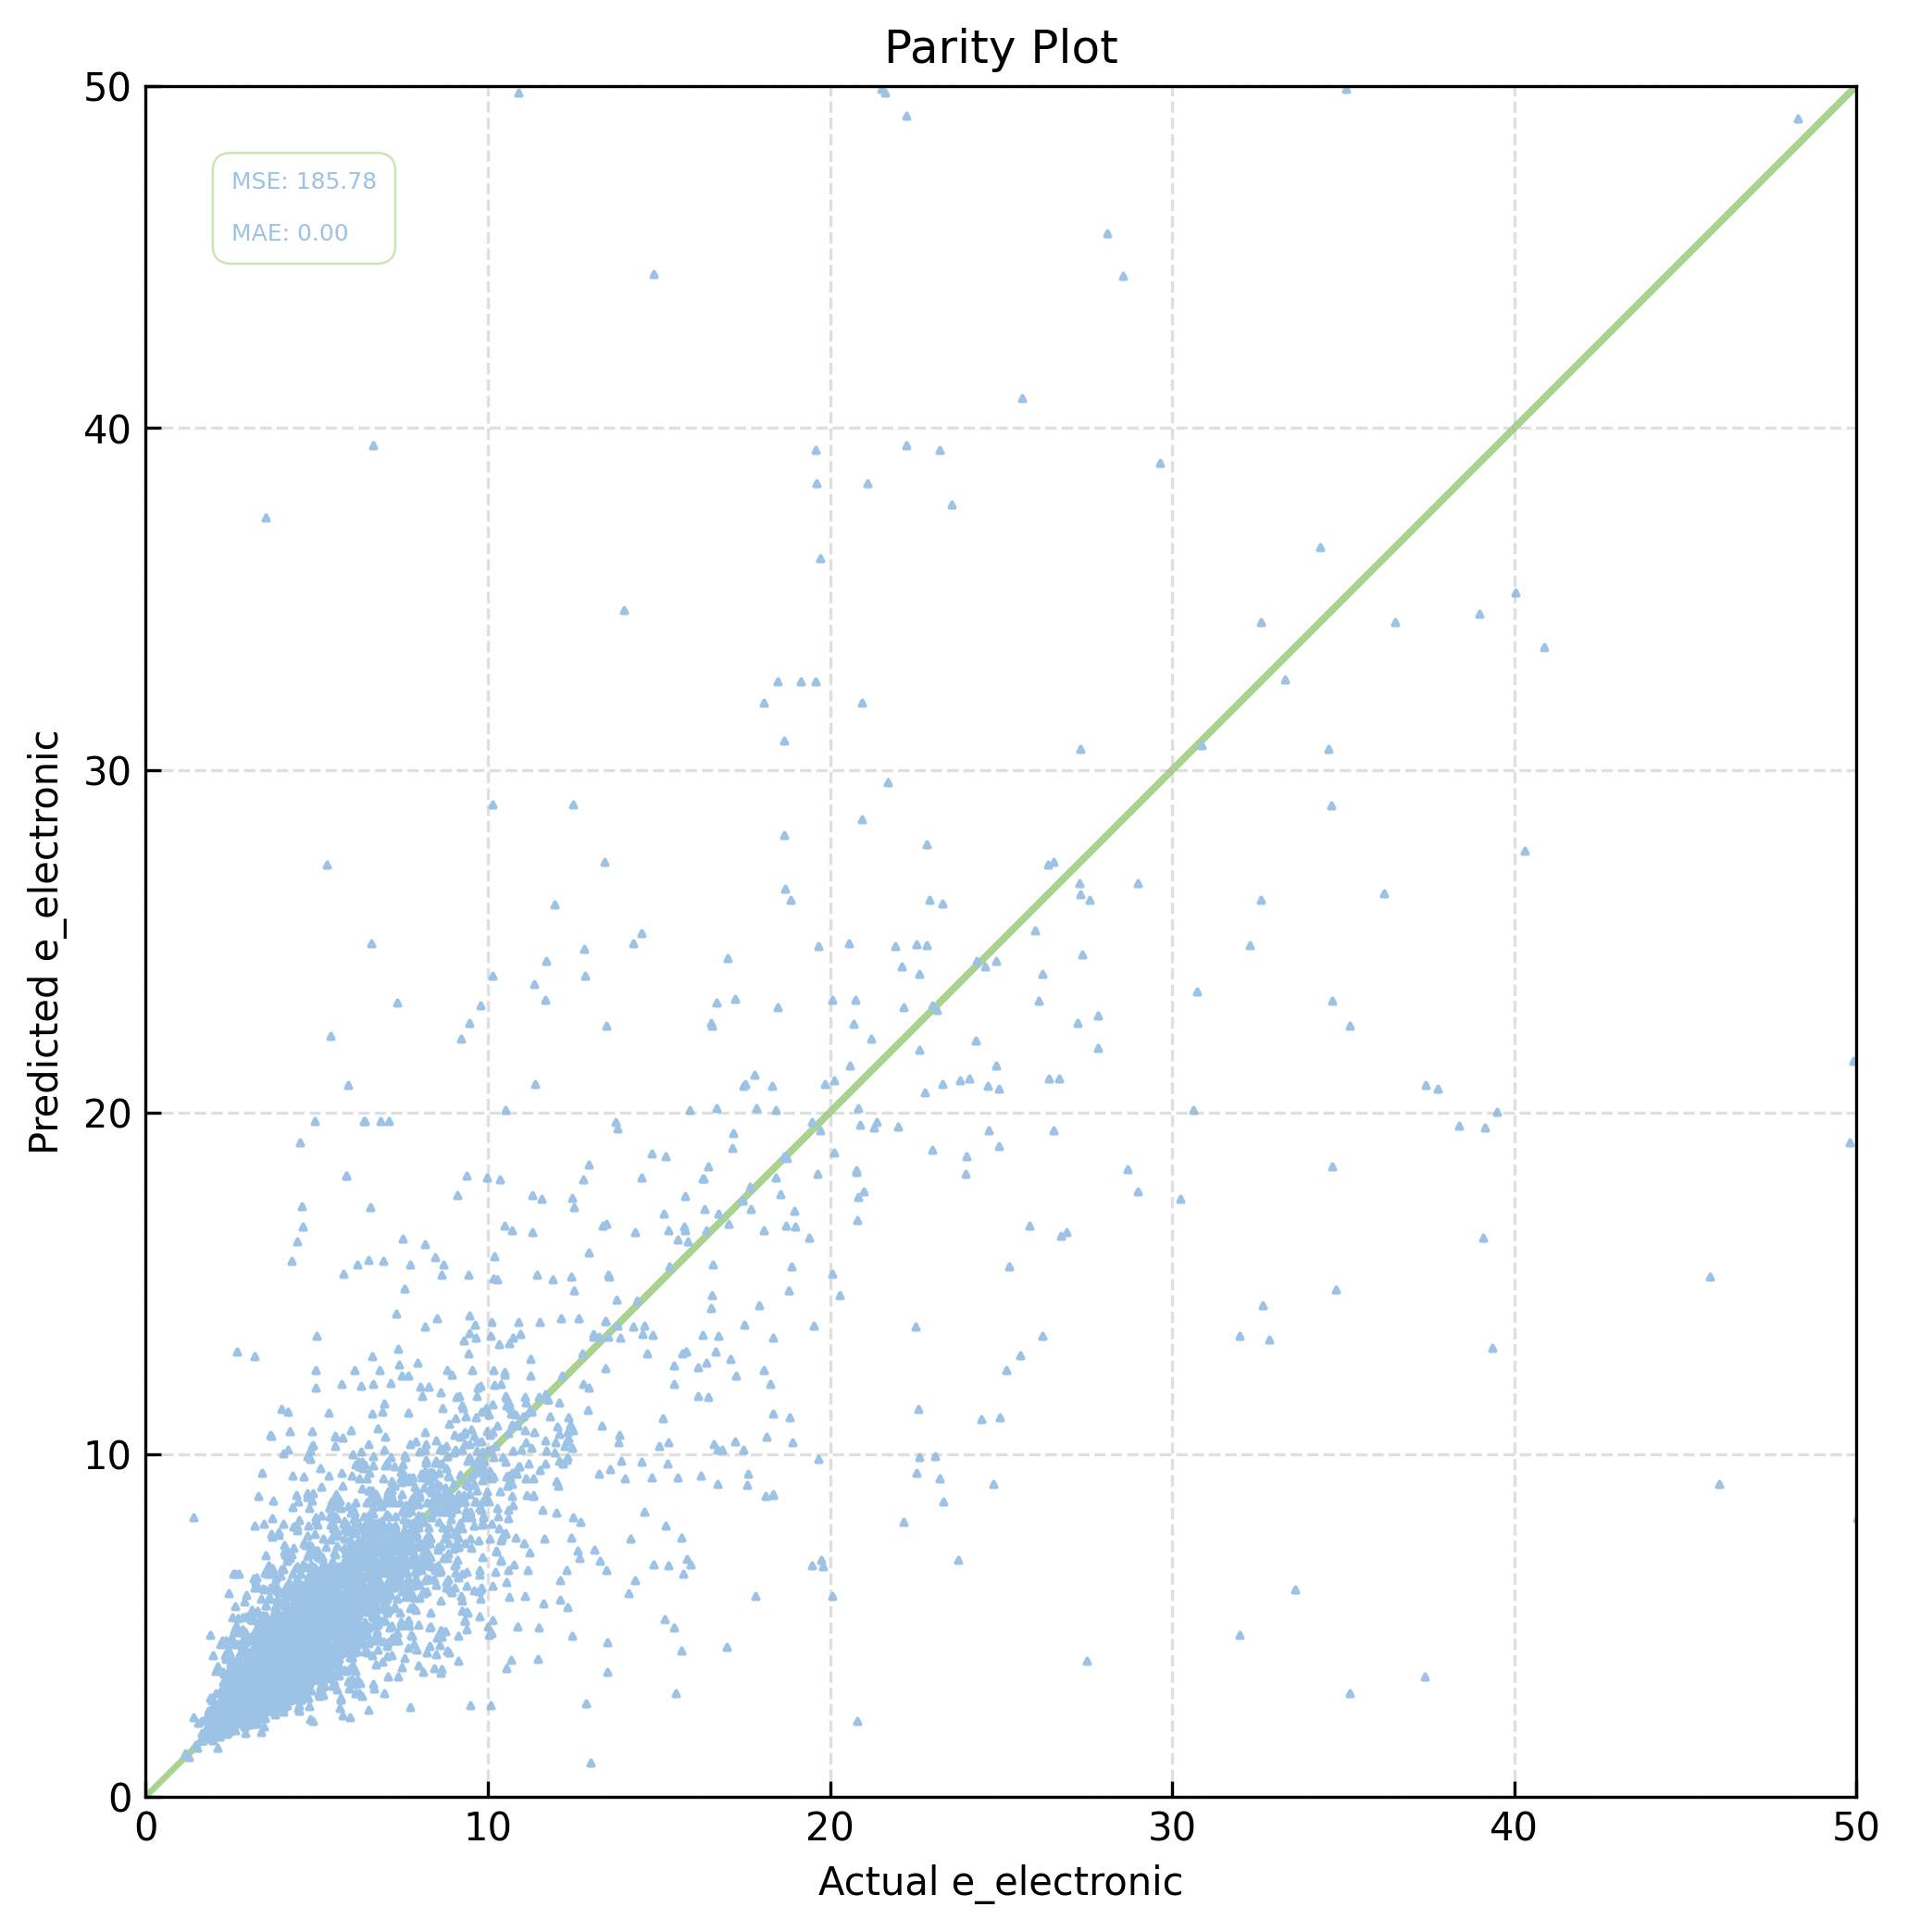

-14.487777854718885 18
Best depth: 17


In [16]:
from sklearn.tree import DecisionTreeRegressor, plot_tree       # ML model

# decide the best depth of the decision tree
max_scores=-1e5
BEST_DEPTH=0
for depth in range(5, 19):
    dt = DecisionTreeRegressor(max_depth=depth,random_state=RANDOM_STATE)      # decision tree constructor
    scores, y_hat = model_cross_train(dt, X_train_scaled, y_train)     
    print(scores.mean(), depth)                         
    if scores.mean() > max_scores:
        max_scores = scores.mean()
        BEST_DEPTH = depth
        plot_scores(scores.mean()**2,0, y_train, y_hat)

print(f'Best depth: {BEST_DEPTH}')

### Model Train

In [17]:
dt = DecisionTreeRegressor(max_depth=BEST_DEPTH, random_state=RANDOM_STATE)
dt = model_final_train(dt, X_train_scaled, y_train)

### Model Test

MSE: 178.2770656170845, MAE: 2.355988635456054


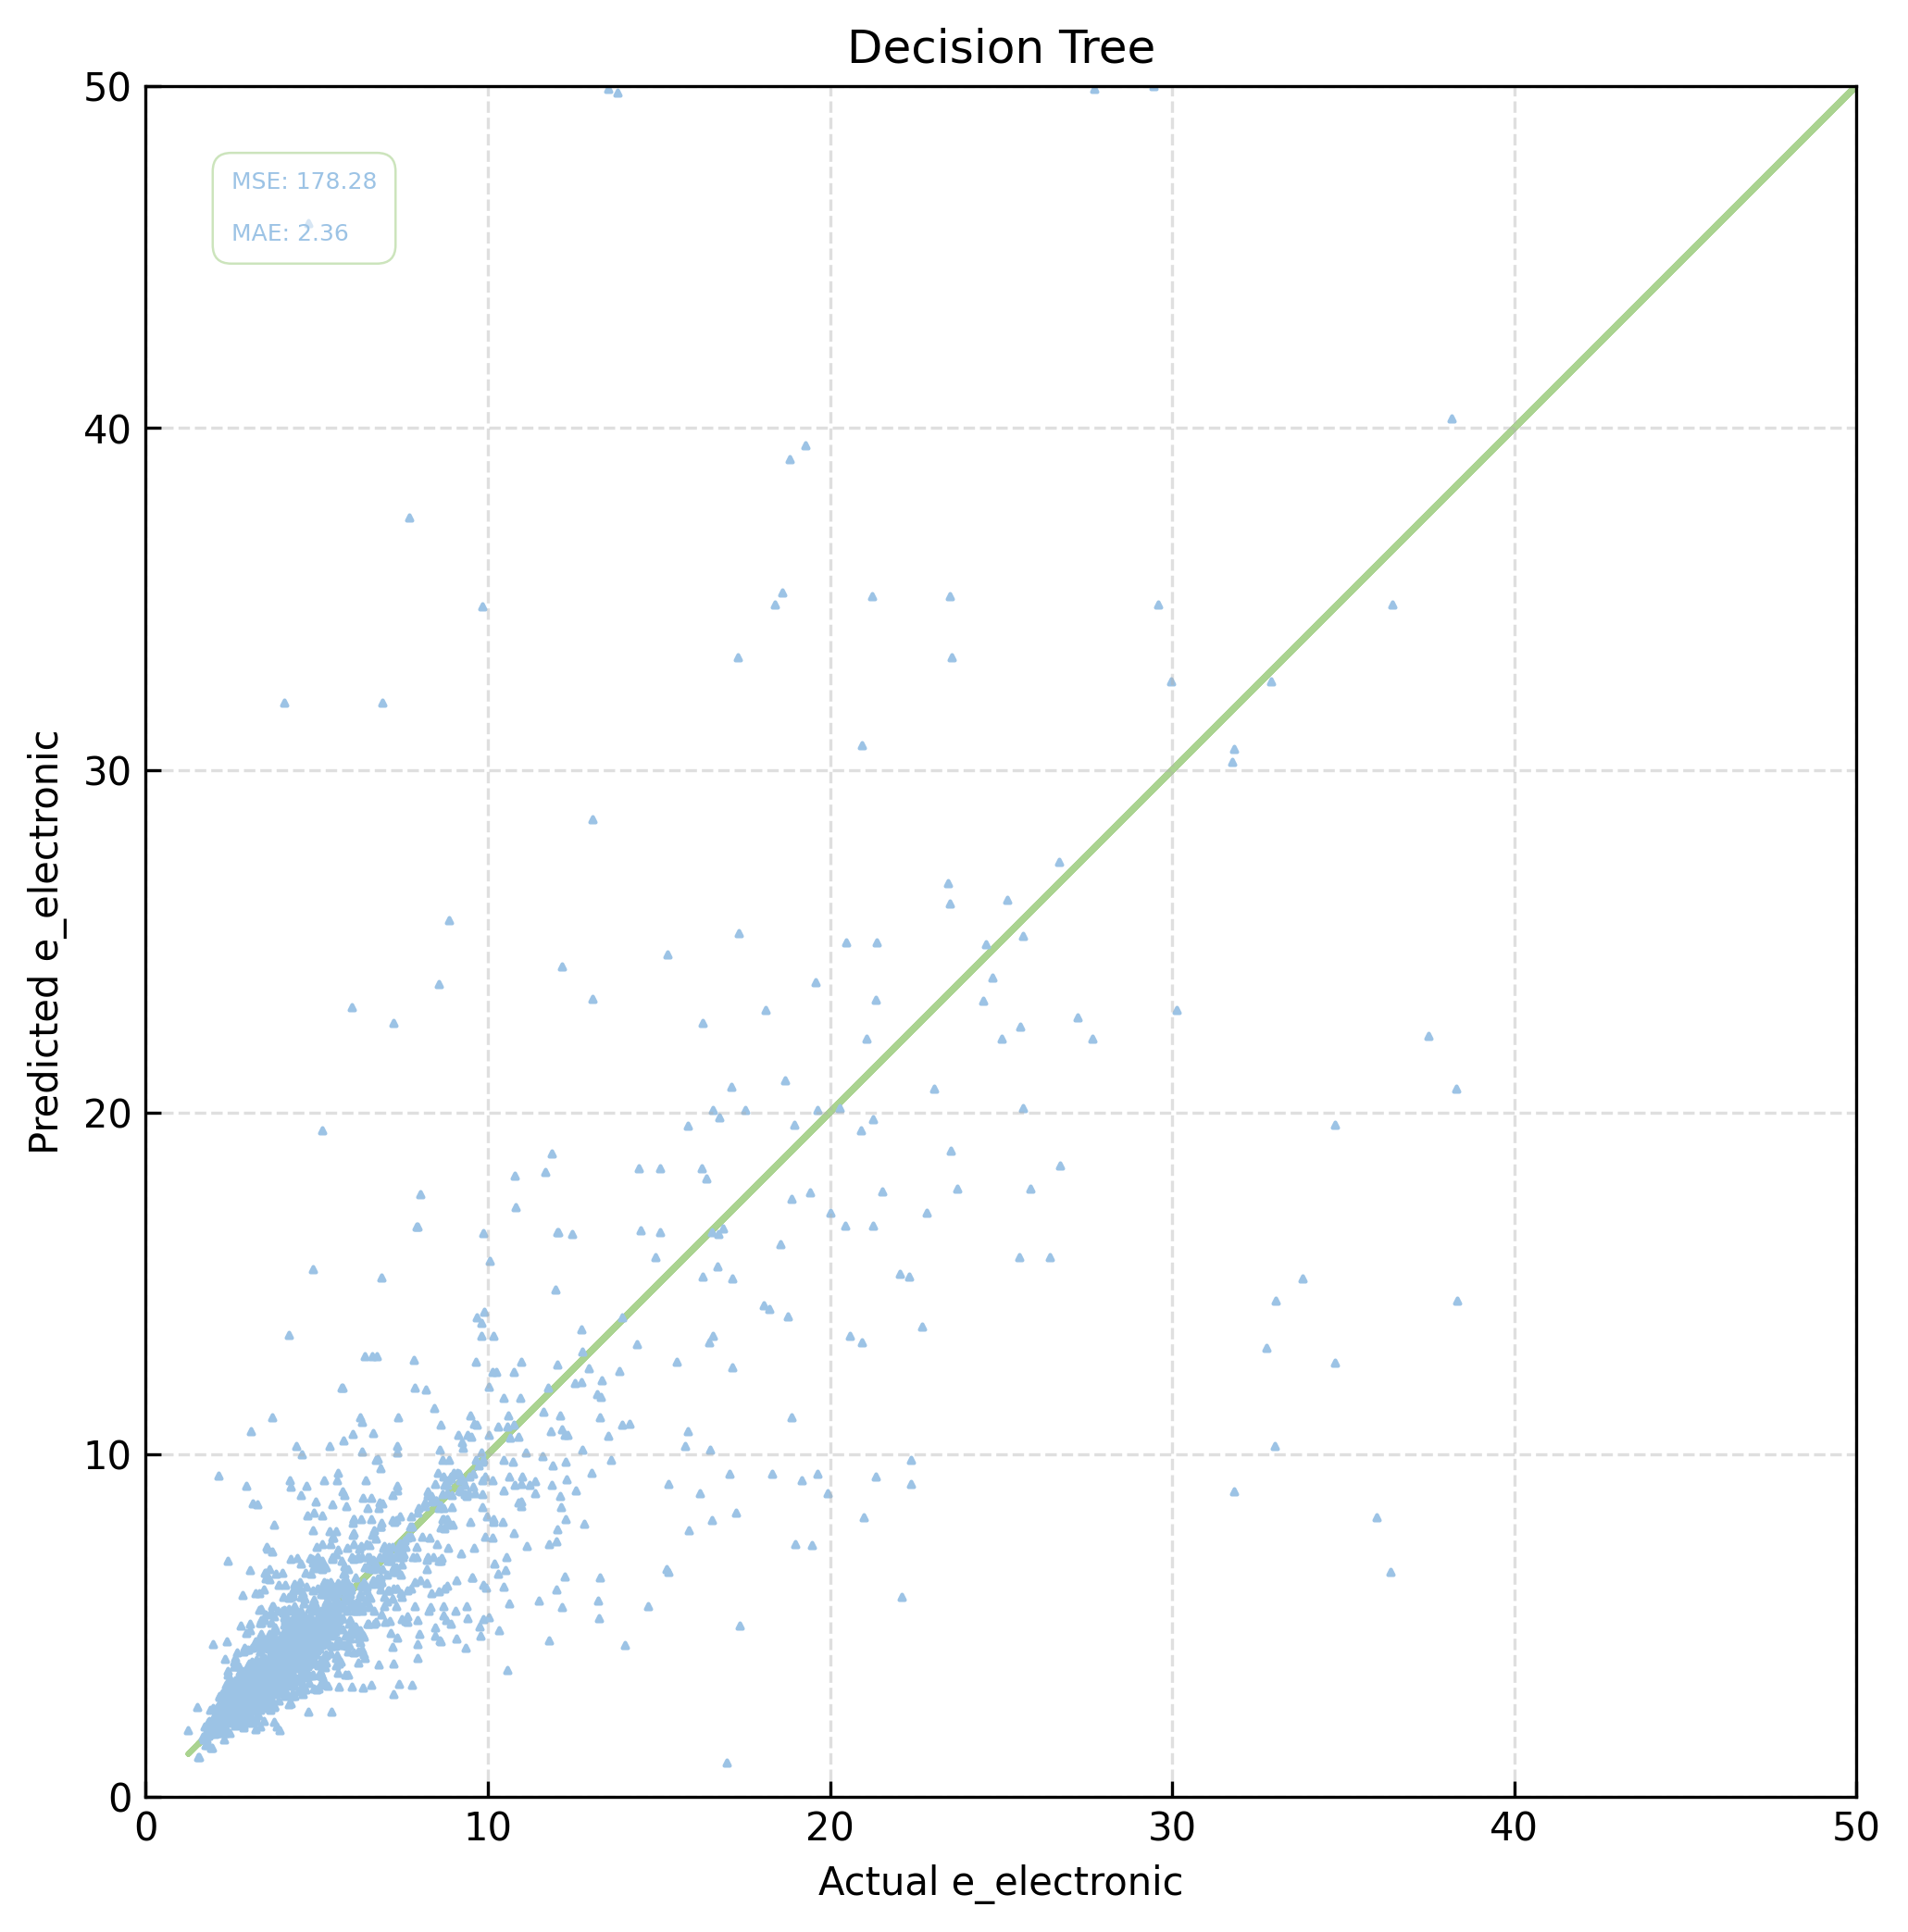

In [18]:
mse, mae, y_pred = model_test(dt, X_test_scaled, y_test)
plot_scores(mse, mae, y_test, y_pred, title='Decision Tree', fig_path=FIG_PATH)

- get the feature importance of the decision tree model

In [19]:
# feature importance
importance = dt.feature_importances_
importance = pd.DataFrame(importance, index=X.columns, columns=["Importance"])
importance = importance.sort_values(by="Importance", ascending=False)
importance

,Importance
band_gap,0.186773
formation_energy_per_atom,0.172096
density_atomic,0.144972
MagpieData mean Electronegativity,0.110483
volume,0.105258
MagpieData minimum CovalentRadius,0.076529
MagpieData range Number,0.045684
MagpieData maximum Electronegativity,0.039643
density,0.039524
MagpieData range Electronegativity,0.026720


In [20]:
importance.reset_index(inplace=True)
importance.columns = ['Feature', 'Importance']
importance

,Feature,Importance
0,band_gap,0.186773
1,formation_energy_per_atom,0.172096
2,density_atomic,0.144972
3,MagpieData mean Electronegativity,0.110483
4,volume,0.105258
5,MagpieData minimum CovalentRadius,0.076529
6,MagpieData range Number,0.045684
7,MagpieData maximum Electronegativity,0.039643
8,density,0.039524
9,MagpieData range Electronegativity,0.026720


In [21]:
list(importance['Feature'][:10])

['band_gap',
 'formation_energy_per_atom',
 'density_atomic',
 'MagpieData mean Electronegativity',
 'volume',
 'MagpieData minimum CovalentRadius',
 'MagpieData range Number',
 'MagpieData maximum Electronegativity',
 'density',
 'MagpieData range Electronegativity']

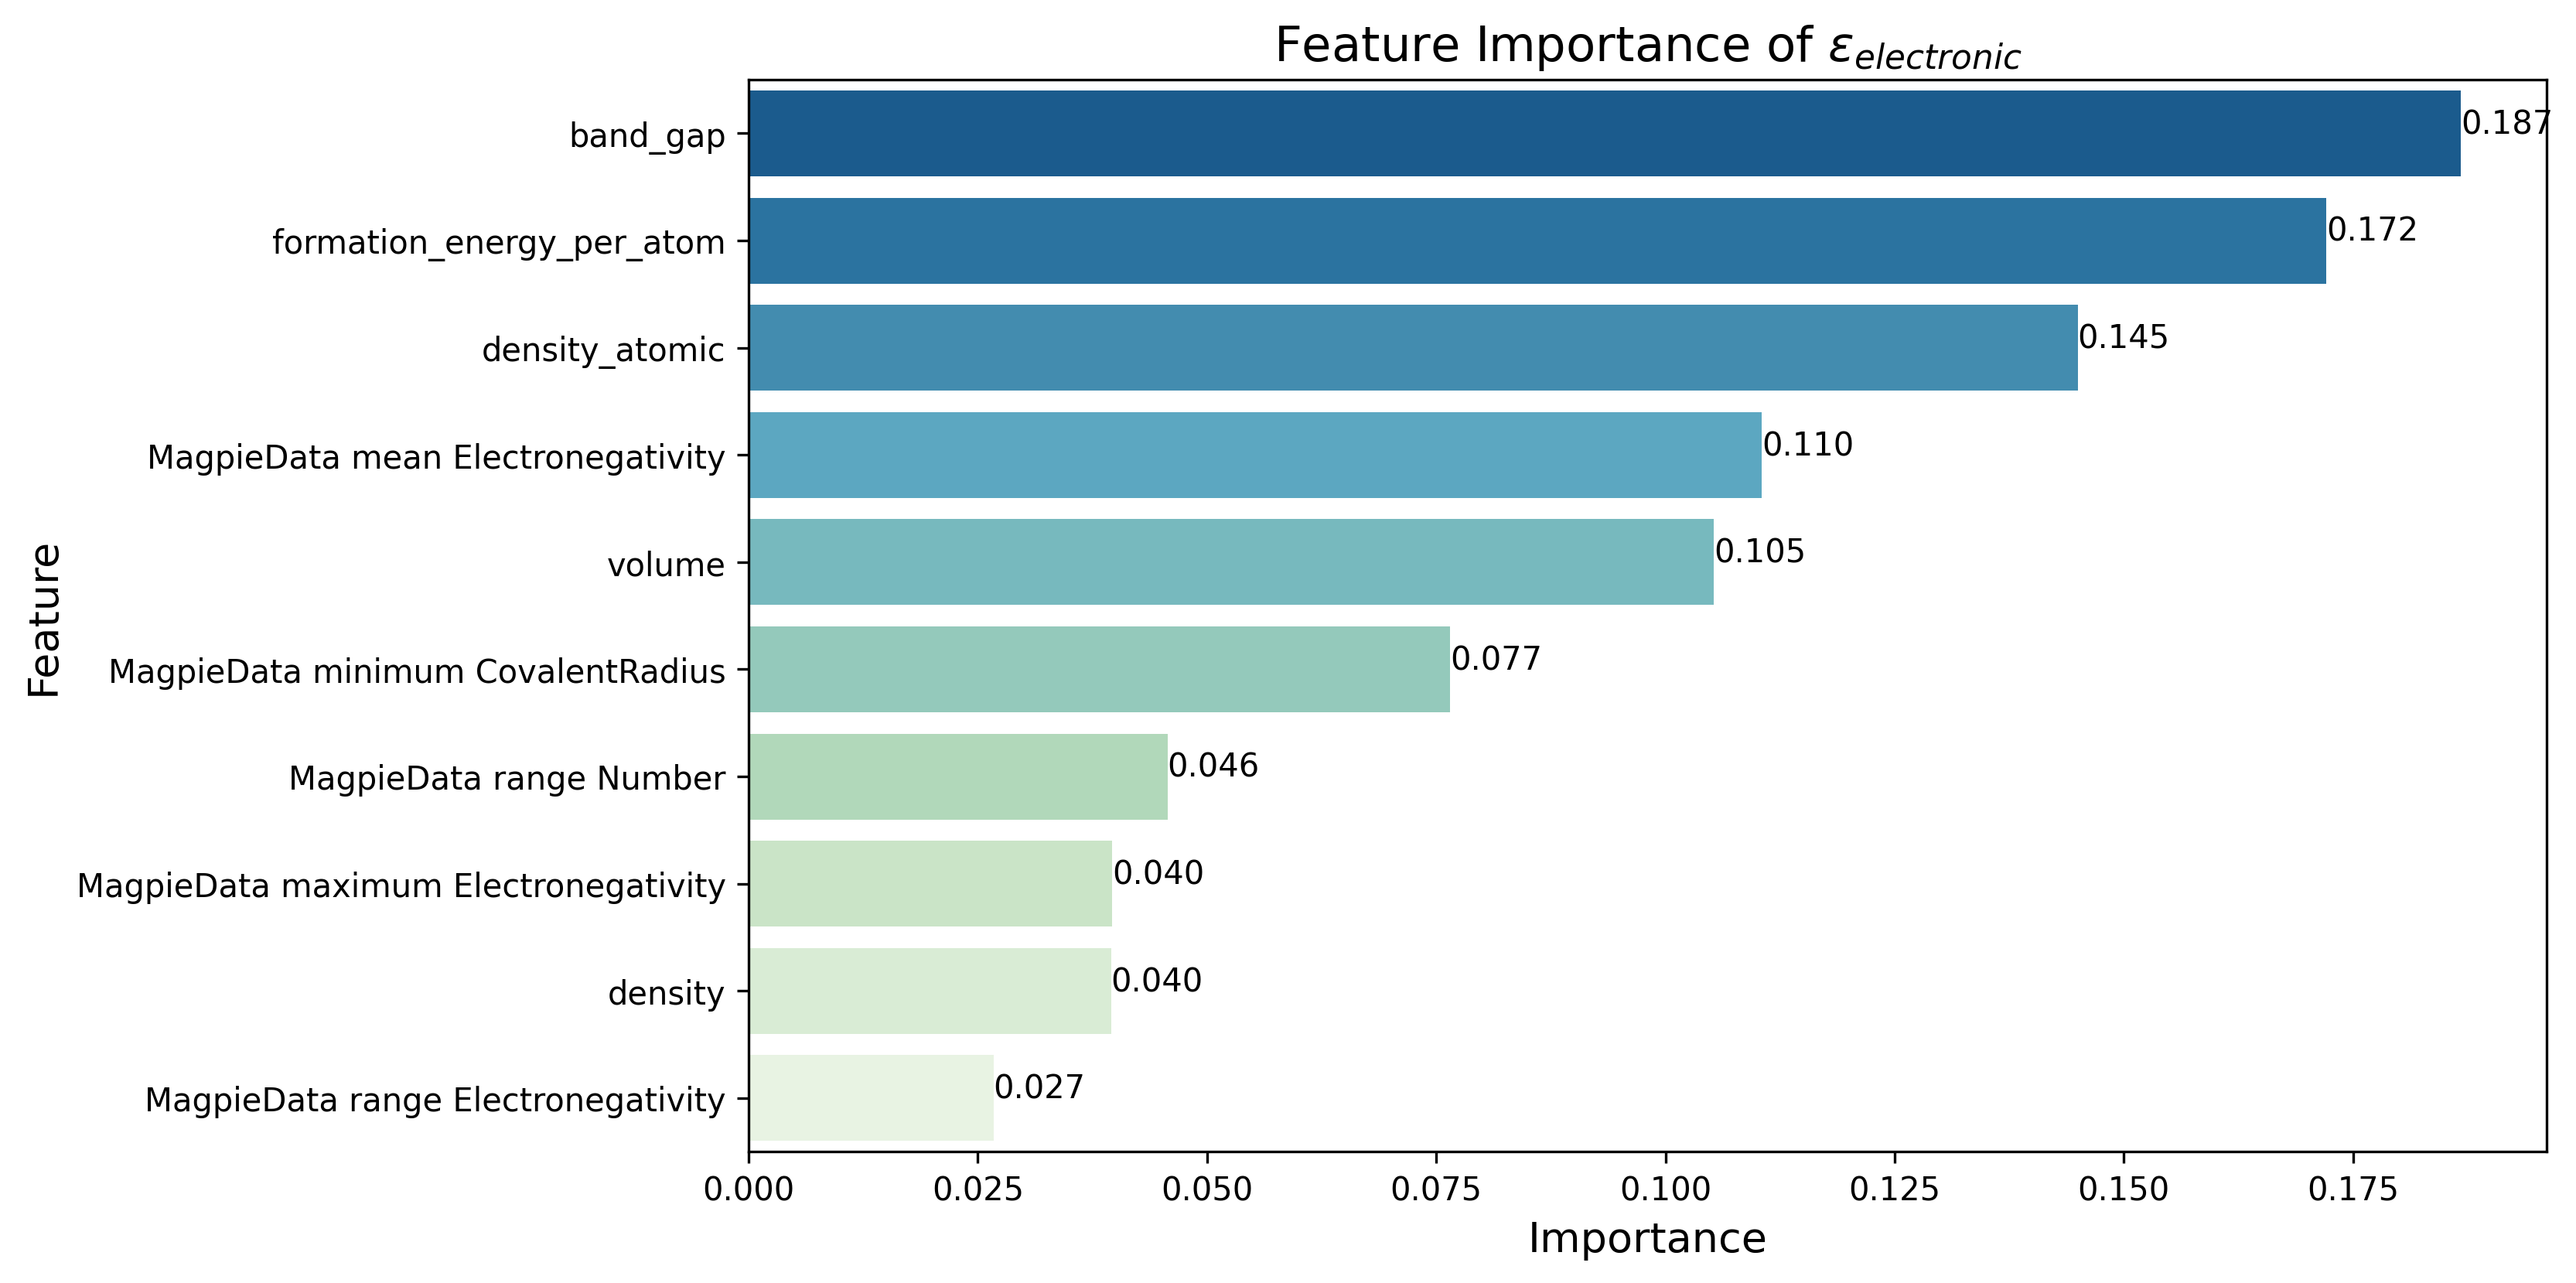

In [22]:
# Visualization of feature importance
import seaborn as sns

# 
fig = plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(x='Importance', y='Feature', data=importance.iloc[:10], palette='GnBu_r', hue='Feature')
# show importance value
for i in range(10):
    plt.text(importance.iloc[i, 1], i, f'{importance.iloc[i, 1]:.3f}')
plt.xlabel('Importance', size=13)
plt.ylabel('Feature', size=13)
plt.title('Feature Importance of $\epsilon_{electronic}$', size=15)
plt.show()
# save the figure
fig.savefig(FIG_PATH+'feature_importance.png', dpi=300, bbox_inches='tight')


### Visualize the decision tree

In [23]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from pydotplus import graph_from_dot_data

In [24]:
# There're so big a tree! so we comment it.
# # create 
# dot_data = export_graphviz(dt, out_file=None, 
#                            filled=True, rounded=True,  
#                            special_characters=True)

# # 
# graph = graph_from_dot_data(dot_data) 

# # save picture
# graph.write_png(FIG_PATH+'decision_tree.png')


## Random Forest Model

In [25]:
from sklearn.ensemble import RandomForestRegressor

### Model Train

In [26]:
rf = RandomForestRegressor(n_estimators=100, max_depth=BEST_DEPTH, random_state=RANDOM_STATE)
rf = model_final_train(rf, X_train_scaled, y_train)

### Model Test

MSE: 105.00151971358511, MAE: 1.9398928220002205


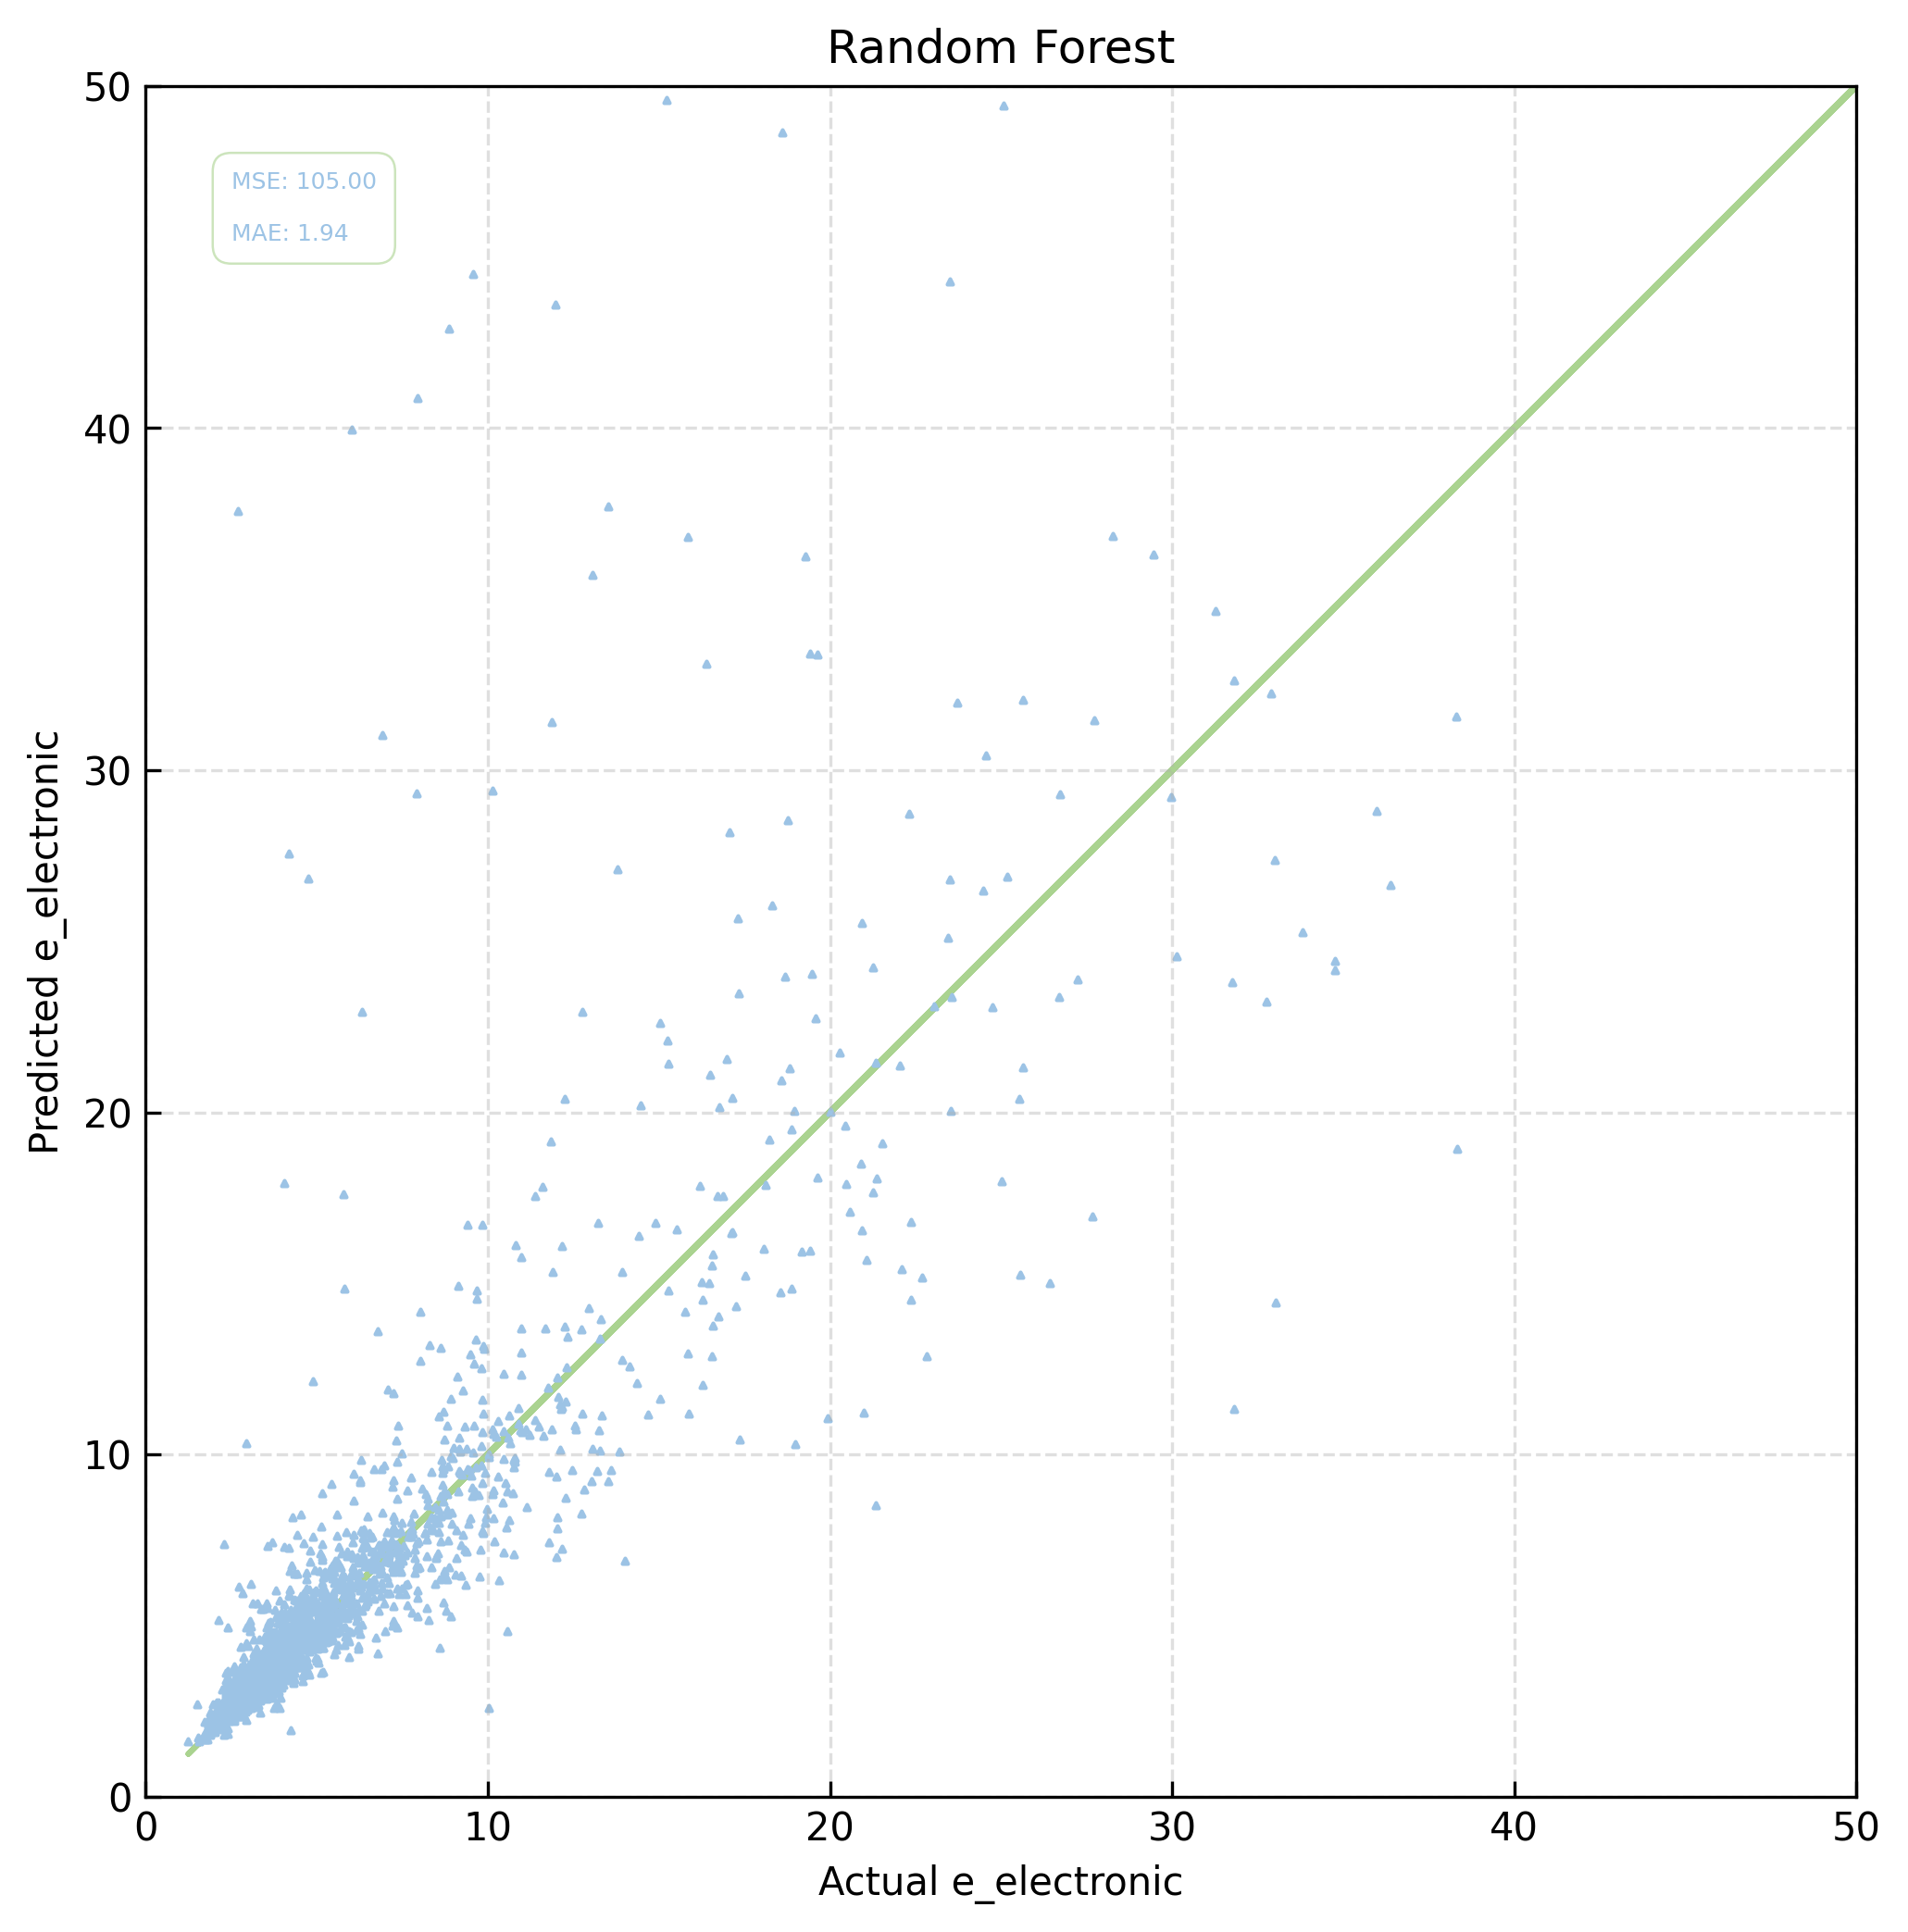

In [27]:
mse, mae, y_pred = model_test(rf, X_test_scaled, y_test)
plot_scores(mse, mae, y_test, y_pred, title='Random Forest', fig_path=FIG_PATH)